In [1]:
from keras.models import Sequential
from keras.layers import Dense, Activation,Dropout

import ROOT as rt
import uproot
#from root_numpy import root2array, tree2array
#from root_pandas import read_root
import h5py 

from keras.optimizers import Adam
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args

import numpy as np
import numpy.lib.recfunctions as nlr
import pandas as pd
import os, sys
from matplotlib import pyplot as plt
import math
try:
    import setGPU
except:
    os.environ['KERAS_BACKEND'] = 'tensorflow'
    os.environ['CUDA_VISIBLE_DEVICES'] = '5'

Welcome to JupyROOT 6.22/02
setGPU: Setting GPU to: 0


### Set-up Dataframes

In [2]:
def samp_to_df(samp_name, total_num):
    dfs = []
    for i in range(total_num+1):
        file_name = f'/storage/af/user/schen7/CMSSW_9_4_2/src/Higgs/HHbbgg/HHbbggAna/condor/output/{samp_name}{i}.root'
        samp_file = uproot.open(file_name)
        samp_array = samp_file['tree'].arrays()
        samp_df = pd.DataFrame(samp_array)
        dfs.append(samp_df)
    combine_df = pd.concat(dfs, ignore_index=True)
    return combine_df

In [3]:
# Set up dataframes - 2018 

# Signals
GluGluToHH_df_2018 = samp_to_df('job_2_ntuple20180819v1/GluGluToHHTo2B2G_node_cHHH1_TuneCP5_PSWeights_13TeV-powheg-pythia8Job2ifile', 0)
VBFHH_df_2018= samp_to_df('job_3_ntuple20180819v1/VBFHHTo2B2G_CV_1_C2V_1_C3_1_TuneCP5_PSWeights_13TeV-madgraph-pythia8Job3ifile', 0)

# Backgrounds
VHToGG_df_2018 = samp_to_df('job_4_ntuple20180819v1/VHToGG_M125_13TeV_amcatnloFXFX_madspin_pythia8Job4ifile', 0)
ttHToGG_df_2018 = samp_to_df('job_5_ntuple20180819v1/ttHToGG_M125_TuneCP5_PSweights_13TeV-powheg-pythia8Job5ifile', 0)
VBFHToGG_df_2018 = samp_to_df('job_6_ntuple20180819v1/VBFHToGG_M125_13TeV_amcatnlo_pythia8Job6ifile', 0)
GluGluHToGG_df_2018 = samp_to_df('job_7_ntuple20180819v1/GluGluHToGG_M125_TuneCP5_13TeV-amcatnloFXFX-pythia8Job7ifile', 0)
TTJets_df_2018 = samp_to_df('job_8_ntuple20180819v1/TTJets_TuneCP5_13TeV-amcatnloFXFX-pythia8Job8ifile', 60)
TTGJets_df_2018 = samp_to_df('job_9_ntuple20180819v1/TTGJets_TuneCP5_13TeV-amcatnloFXFX-madspin-pythia8Job9ifile', 3)
TTGG_0Jets_df_2018 = samp_to_df('job_10_ntuple20180819v1/TTGG_0Jets_TuneCP5_13TeV_amcatnlo_madspin_pythia8Job10ifile', 5)
GJet_SmallPt_df_2018 = samp_to_df('job_11_ntuple20180819v1/GJet_Pt-20to40_DoubleEMEnriched_MGG-80toInf_TuneCP5_13TeV_Pythia8Job11ifile', 3)
GJet_BigPt_df_2018 = samp_to_df('job_12_ntuple20180819v1/GJet_Pt-40toInf_DoubleEMEnriched_MGG-80toInf_TuneCP5_13TeV_Pythia8Job12ifile', 2)
DiPhotonJetsBox_df_2018 = samp_to_df('job_13_ntuple20180819v1/DiPhotonJetsBox_MGG-80toInf_13TeV-SherpaJob13ifile', 4)
DiPhotonJetsBox1B_df_2018 = samp_to_df('job_14_ntuple20180819v1/DiPhotonJetsBox1BJet_MGG-80toInf_13TeV-SherpaJob14ifile', 0)
DiPhotonJetsBox2B_df_2018 = samp_to_df('job_15_ntuple20180819v1/DiPhotonJetsBox2BJets_MGG-80toInf_13TeV-SherpaJob15ifile', 0)
QCD_Jets_df_2018 = samp_to_df('job_16_ntuple20180819v1/QCD_Pt-40toInf_DoubleEMEnriched_MGG-80toInf_TuneCP5_13TeV_Pythia8Job16ifile', 15)

# Set up dataframes - 2017

# Signals
GluGluToHH_df_2017 = samp_to_df('job_2_ntuple20170819v1/GluGluToHHTo2B2G_node_cHHH1_TuneCP5_PSWeights_13TeV-powheg-pythia8Job2ifile', 3)
VBFHH_df_2017 = samp_to_df('job_3_ntuple20170819v1/VBFHHTo2B2G_CV_1_C2V_1_C3_1_13TeV-madgraphJob3ifile', 1)

# Backgrounds
VHToGG_df_2017 = samp_to_df('job_4_ntuple20170819v1/VHToGG_M125_13TeV_amcatnloFXFX_madspin_pythia8Job4ifile', 0)
ttHToGG_df_2017 = samp_to_df('job_5_ntuple20170819v1/ttHToGG_M125_13TeV_powheg_pythia8Job5ifile', 0)
VBFHToGG_df_2017 = samp_to_df('job_6_ntuple20170819v1/VBFHToGG_M-125_13TeV_powheg_pythia8Job6ifile', 2)
GluGluHToGG_df_2017 = samp_to_df('job_7_ntuple20170819v1/GluGluHToGG_M-125_13TeV_powheg_pythia8Job7ifile', 0)
TTJets_df_2017 = samp_to_df('job_8_ntuple20170819v1/TTJets_TuneCP5_13TeV-amcatnloFXFX-pythia8Job8ifile', 38)
TTGJets_df_2017 = samp_to_df('job_9_ntuple20170819v1/TTGJets_TuneCP5_13TeV-amcatnloFXFX-madspin-pythia8Job9ifile', 10)
TTGG_0Jets_df_2017 = samp_to_df('job_10_ntuple20170819v1/TTGG_0Jets_TuneCP5_13TeV_amcatnlo_madspin_pythia8Job10ifile', 1)
GJet_SmallPt_df_2017 = samp_to_df('job_11_ntuple20170819v1/GJet_Pt-20to40_DoubleEMEnriched_MGG-80toInf_TuneCP5_13TeV_Pythia8Job11ifile', 2)
GJet_BigPt_df_2017 = samp_to_df('job_12_ntuple20170819v1/GJet_Pt-40toInf_DoubleEMEnriched_MGG-80toInf_TuneCP5_13TeV_Pythia8Job12ifile', 20)
DiPhotonJetsBox_df_2017 = samp_to_df('job_1_ntuple20170819v2/DiPhotonJetsBox_MGG-80toInf_13TeV-SherpaJob1ifile', 16)
DiPhotonJetsBox1B_df_2017 = samp_to_df('job_14_ntuple20170819v1/DiPhotonJetsBox1BJet_MGG-80toInf_13TeV-SherpaJob14ifile', 3)
DiPhotonJetsBox2B_df_2017 = samp_to_df('job_15_ntuple20170819v1/DiPhotonJetsBox2BJets_MGG-80toInf_13TeV-SherpaJob15ifile', 5)
QCD_Jets_df_2017 = samp_to_df('job_16_ntuple20170819v1/QCD_Pt-40toInf_DoubleEMEnriched_MGG-80toInf_TuneCP5_13TeV_Pythia8Job16ifile', 3)

# Set up dataframes - 2016 

# Signals
GluGluToHH_df_2016 = samp_to_df('job_2_ntuple20160819v1/GluGluToHHTo2B2G_node_cHHH1_TuneCUETP8M1_PSWeights_13TeV-powheg-pythia8Job2ifile', 0)
VBFHH_df_2016 = samp_to_df('job_3_ntuple20160819v1/VBFHHTo2B2G_CV_1_C2V_1_C3_1_13TeV-madgraphJob3ifile', 0)

# Background
VHToGG_df_2016 = samp_to_df('job_4_ntuple20160819v1/VHToGG_M125_13TeV_amcatnloFXFX_madspin_pythia8Job4ifile', 0)
ttHToGG_df_2016 = samp_to_df('job_5_ntuple20160819v1/ttHToGG_M125_13TeV_powheg_pythia8_v2Job5ifile', 0)
VBFHToGG_df_2016 = samp_to_df('job_6_ntuple20160819v1/VBFHToGG_M125_13TeV_amcatnlo_pythia8_v2Job6ifile', 2)
GluGluHToGG_df_2016 = samp_to_df('job_7_ntuple20160819v1/GluGluHToGG_M125_13TeV_amcatnloFXFX_pythiaJob7ifile', 0)
TTJets_df_2016 = samp_to_df('job_8_ntuple20160819v1/TTJets_TuneCUETP8M2T4_13TeV-amcatnloFXFX-pythia8Job8ifile', 8)
TTGJets_df_2016 = samp_to_df('job_9_ntuple20160819v1/TTGJets_TuneCUETP8M1_13TeV-amcatnloFXFX-madspin-pythia8Job9ifile', 2)
TTGG_0Jets_df_2016 = samp_to_df('job_10_ntuple20160819v1/TTGG_0Jets_TuneCUETP8M1_13TeV_amcatnlo_madspin_pythia8Job10ifile', 0)
GJet_SmallPt_df_2016 = samp_to_df('job_11_ntuple20160819v1/GJet_Pt-20to40_DoubleEMEnriched_MGG-80toInf_TuneCUETP8M1_13TeV_Pythia8Job11ifile', 2)
GJet_BigPt_df_2016 = samp_to_df('job_12_ntuple20160819v1/GJet_Pt-40toInf_DoubleEMEnriched_MGG-80toInf_TuneCUETP8M1_13TeV_Pythia8Job12ifile', 12)
DiPhotonJetsBox_df_2016 = samp_to_df('job_13_ntuple20160819v1/DiPhotonJetsBox_MGG-80toInf_13TeV-SherpaJob13ifile', 9)
DiPhotonJetsBox1B_df_2016 = samp_to_df('job_14_ntuple20160819v1/DiPhotonJetsBox1BJet_MGG-80toInf_TuneSherpa_13TeV-SherpaJob14ifile', 3)
DiPhotonJetsBox2B_df_2016 = samp_to_df('job_15_ntuple20160819v1/DiPhotonJetsBox2BJets_MGG-80toInf_TuneSherpa_13TeV-SherpaJob15ifile', 4)
QCD_Jets_df_2016 = samp_to_df('job_16_ntuple20160819v1/QCD_Pt-40toInf_DoubleEMEnriched_MGG-80toInf_TuneCUETP8M1_13TeV_Pythia8Job16ifile', 3)

# Combine by sample (recon == 1; photon cut == 90)

# Signals 
GluGluToHH_df = pd.concat([GluGluToHH_df_2018, GluGluToHH_df_2017, GluGluToHH_df_2016], ignore_index=True)
VBFHH_df = pd.concat([VBFHH_df_2018, VBFHH_df_2017, VBFHH_df_2016], ignore_index=True)

# Backgrounds
VHToGG_df = pd.concat([VHToGG_df_2018, VHToGG_df_2017, VHToGG_df_2016], ignore_index=True)
ttHToGG_df = pd.concat([ttHToGG_df_2018, ttHToGG_df_2017, ttHToGG_df_2016], ignore_index=True)
VBFHToGG_df = pd.concat([VBFHToGG_df_2018, VBFHToGG_df_2017, VBFHToGG_df_2016], ignore_index=True)
GluGluHToGG_df = pd.concat([GluGluHToGG_df_2018, GluGluHToGG_df_2017, GluGluHToGG_df_2016], ignore_index=True)
TTJets_df= pd.concat([TTJets_df_2018, TTJets_df_2017, TTJets_df_2016], ignore_index=True)
TTGJets_df = pd.concat([TTGJets_df_2018, TTGJets_df_2017, TTGJets_df_2016], ignore_index=True)
TTGG_0Jets_df = pd.concat([TTGG_0Jets_df_2018, TTGG_0Jets_df_2017, TTGG_0Jets_df_2016], ignore_index=True)
GJet_SmallPt_df = pd.concat([GJet_SmallPt_df_2018, GJet_SmallPt_df_2017, GJet_SmallPt_df_2016], ignore_index=True)
GJet_BigPt_df = pd.concat([GJet_BigPt_df_2018, GJet_BigPt_df_2017, GJet_BigPt_df_2016], ignore_index=True)
DiPhotonJetsBox_df = pd.concat([DiPhotonJetsBox_df_2018, DiPhotonJetsBox_df_2017, DiPhotonJetsBox_df_2016], ignore_index=True)
DiPhotonJetsBox1B_df = pd.concat([DiPhotonJetsBox1B_df_2018, DiPhotonJetsBox1B_df_2017, DiPhotonJetsBox1B_df_2016], ignore_index=True)
DiPhotonJetsBox2B_df = pd.concat([DiPhotonJetsBox2B_df_2018, DiPhotonJetsBox2B_df_2017, DiPhotonJetsBox2B_df_2016], ignore_index=True)
QCD_Jets_df = pd.concat([QCD_Jets_df_2018, QCD_Jets_df_2017, QCD_Jets_df_2016], ignore_index=True)


# Set up signal specific dfs -- pho == 90
mc_labels = ['GluGlutoHH','VBFToHH',
            'VHToGG', 'ttHToGG', 'VBFHToGG', 'GluGluHtoGG',
            'TTJets', 'TTGJets', 'TTGG_0Jets',
            'GJet_SmallPt', 'GJet_BigPt', 'DiPhotonJetsBox', 'DiPhotonJetsBox1B', 'DiPhotonJetsBox2B', 'QCDJets']


dfs_combine = [GluGluToHH_df, VBFHH_df,
               VHToGG_df, ttHToGG_df, VBFHToGG_df, GluGluHToGG_df, 
                TTJets_df, TTGJets_df, TTGG_0Jets_df, 
            GJet_SmallPt_df, GJet_BigPt_df,
             DiPhotonJetsBox_df, DiPhotonJetsBox1B_df, DiPhotonJetsBox2B_df, QCD_Jets_df]

dfs_ggHH = []

for i in range(len(dfs_combine)):
    df_ggHH = dfs_combine[i][dfs_combine[i][b'ggHH_recon'] == 1]
    dfs_ggHH.append(df_ggHH)

dfs_ggHH_label = []
total = 0
for i in range(len(mc_labels)):
    df = pd.DataFrame()
    for column in list(dfs_ggHH[i].columns):
        df[column] = dfs_ggHH[i].loc[:, column].values
    samp_label = [mc_labels[i]] * len(dfs_ggHH[i].index)
    df[b'label'] = samp_label
    print(mc_labels[i])
    print(len(dfs_ggHH[i].index))
    total += len(dfs_ggHH[i].index)
    samp_label_num = [i] * len(dfs_ggHH[i].index)
    df[b'label_num'] = samp_label_num
    dfs_ggHH_label.append(df)

GluGlutoHH
115095
VBFToHH
123786
VHToGG
150739
ttHToGG
128314
VBFHToGG
117796
GluGluHtoGG
131781
TTJets
233707
TTGJets
80870
TTGG_0Jets
45301
GJet_SmallPt
2565
GJet_BigPt
78388
DiPhotonJetsBox
1970698
DiPhotonJetsBox1B
79813
DiPhotonJetsBox2B
43283
QCDJets
414


In [4]:
training_vars = [b'leading_photon_eta', b'leading_photon_phi', 
                b'subleading_photon_eta', b'subleading_photon_phi',
                 b'leading_bjet_pt_corr', b'leading_bjet_eta', b'leading_bjet_phi',
                 b'subleading_bjet_pt_corr', b'subleading_bjet_eta', b'subleading_bjet_phi',
                 b'leadingDeepBscore', b'subleadingDeepBscore', b'sumDeepBscore',
                 b'leading_pho_pt_over_dimass', b'subleading_pho_pt_over_dimass',
                 b'diphoton_pt_over_diphoton_mass', b'dibjet_pt_over_dibjet_mass_corr',
                 b'rec_pho_bjet_min_dR', b'all_pho_bjet_min_dR', b'dphi_met_leading_bjet', b'dphi_met_subleading_bjet',
                 b'MET_pt', b'MET_phi', b'MET_sumEt',
                 b'nbjet', b'nphoton', b'njet'
                ]

aug_vars = [b'dibjet_mass_corr', b'diphoton_mass', b'event', b'label_num']

w_var = [b'genweight']
label_var = [b'label_num']

In [5]:
BKD_dfs = []


for i in range(len(dfs_ggHH_label) - 1):
    BKD_dfs.append(dfs_ggHH_label[i+1])

sig_frame_all = dfs_ggHH_label[0]
bkg_frame_all = pd.concat(BKD_dfs, ignore_index=True)

#print(sig_frame_all.iloc[:1])

#select events with cuts
#https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html

sig_frame = sig_frame_all[training_vars]
bkg_frame = bkg_frame_all[training_vars]


sig_df = sig_frame_all[training_vars + w_var + aug_vars]
bkg_df = bkg_frame_all[training_vars + w_var + aug_vars]

sig_weight = sig_frame_all[w_var]
bkg_weight = bkg_frame_all[w_var]

sig_samp_label = sig_frame_all[label_var]
bkg_samp_label = bkg_frame_all[label_var]

#print(sig_frame[training_vars].head(), bkg_frame[training_vars].head())
#print(sig_frame.head(), bkg_frame.head())

In [6]:
sig_frame_all.head()

,b'run',b'lumi',b'event',b'trig_decision',b'pv_pass',b'njet',b'leading_photon_pt',b'leading_photon_eta',b'leading_photon_phi',b'subleading_photon_pt',...,b'MET_sumEt',b'dphi_met_leading_bjet',b'dphi_met_subleading_bjet',b'fatJetPt',b'fatJetEta',b'fatJetPhi',b'fatJetMassSD_UnCorrected',b'fatJetbtagDDBvL',b'label',b'label_num'
0,1,1121,112017,1,1,6,81.548317,-0.114059,2.528809,68.587204,...,1177.0,0.133484,-1.682007,-999.0,-999.0,-999.0,-999.0,-999.0,GluGlutoHH,0
1,1,1121,112010,1,1,5,109.037231,-0.835327,1.176514,87.997322,...,1778.0,-1.047119,0.026978,-999.0,-999.0,-999.0,-999.0,-999.0,GluGlutoHH,0
2,1,1121,112001,1,1,10,99.698898,-0.390930,-0.474426,54.716755,...,2834.0,0.596680,1.405744,-999.0,-999.0,-999.0,-999.0,-999.0,GluGlutoHH,0
3,1,1121,112006,1,1,13,78.673645,2.106934,-1.360596,74.914726,...,2928.0,1.832520,-0.022339,-999.0,-999.0,-999.0,-999.0,-999.0,GluGlutoHH,0
4,1,1121,112019,1,1,8,447.419708,0.706421,-1.743896,159.403656,...,2456.0,0.226318,-0.302490,-999.0,-999.0,-999.0,-999.0,-999.0,GluGlutoHH,0


In [7]:
bkg_frame_all.head()

,b'run',b'lumi',b'event',b'trig_decision',b'pv_pass',b'njet',b'leading_photon_pt',b'leading_photon_eta',b'leading_photon_phi',b'subleading_photon_pt',...,b'MET_sumEt',b'dphi_met_leading_bjet',b'dphi_met_subleading_bjet',b'fatJetPt',b'fatJetEta',b'fatJetPhi',b'fatJetMassSD_UnCorrected',b'fatJetbtagDDBvL',b'label',b'label_num'
0,1,45,44003,1,1,6,77.957336,1.937012,2.021973,50.194241,...,1395.0,0.102051,2.672607,-999.0,-999.0,-999.0,-999.0,-999.0,VBFToHH,1
1,1,45,44017,1,1,8,136.443726,-0.233734,-0.127197,78.010513,...,1682.0,-0.115723,1.410871,-999.0,-999.0,-999.0,-999.0,-999.0,VBFToHH,1
2,1,45,44030,1,1,7,71.880722,1.415283,-0.473633,66.617630,...,1331.0,-2.157941,1.757202,-999.0,-999.0,-999.0,-999.0,-999.0,VBFToHH,1
3,1,45,44035,1,1,18,63.862873,-2.223145,0.666260,44.992516,...,2882.0,2.124006,-0.737793,-999.0,-999.0,-999.0,-999.0,-999.0,VBFToHH,1
4,1,45,44044,1,1,17,69.556328,-0.254150,2.049805,66.133530,...,3618.0,1.866193,-1.251465,-999.0,-999.0,-999.0,-999.0,-999.0,VBFToHH,1


In [8]:
#bkg_frame.head()
# Standardize
x_mean = bkg_frame.mean()
x_std = bkg_frame.std()

sig_frame = (sig_frame-x_mean)/x_std
bkg_frame = (bkg_frame-x_mean)/x_std
signal = sig_frame.values
background = bkg_frame.values
#print signal, background
signal_all = sig_df.values
background_all = bkg_df.values

# Shuffle before splitting into train-val
randix = np.arange(len(background))
np.random.shuffle(randix)
#np.random.shuffle(background)
#np.random.shuffle(signal)

randix2 = np.arange(len(signal))
np.random.shuffle(randix2)
signal_ = signal[randix2]
signal_all_=signal_all[randix2]
#signal_ = signal_[:len(background)]

background_ = background[randix]
background_all_ = background_all[randix]
#background_ = background_[:len(signal)] # downsampling

sig_label = np.ones(len(signal_))
bkg_label = np.zeros(len(background_))

data = np.concatenate((signal_,background_))
label = np.concatenate((sig_label,bkg_label))
data_all = np.concatenate((signal_all_,background_all_))

sig_weight_np = sig_weight.values
bkg_weight_np = bkg_weight.values
sig_samp_label_np = sig_samp_label.values
bkg_samp_label_np = bkg_samp_label.values
sig_samp_label_np_sfl = sig_samp_label_np[randix2]
bkg_samp_label_np_sfl = bkg_samp_label_np[randix]
sig_weight_np_sfl = sig_weight_np[randix2]
bkg_weight_np_sfl = bkg_weight_np[randix]
weights = np.concatenate((sig_weight_np_sfl, bkg_weight_np_sfl))
samp_labels = np.concatenate((sig_samp_label_np_sfl, bkg_samp_label_np_sfl))

skf = StratifiedKFold(n_splits=5, shuffle=True)
skf.get_n_splits(data, label)
print(skf)

StratifiedKFold(n_splits=5, random_state=None, shuffle=True)


In [9]:
# full df prep
sig_frame_full = sig_frame_all.values
sig_frame_full = sig_frame_full[randix2]
bgd_frame_full = bkg_frame_all.values
bgd_frame_full=bgd_frame_full[randix]
data_full = np.concatenate((sig_frame_full, bgd_frame_full))

In [10]:
for train_index, test_index in skf.split(data, label):
    print("TRAIN:", train_index, "TEST:", test_index)
    x_train, x_test = data[train_index], data[test_index]
    y_train, y_test = label[train_index], label[test_index]
    train_weight, test_weight = weights[train_index], weights[test_index]
    train_samp_labels, test_samp_labels = samp_labels[train_index], samp_labels[test_index]
    x_all_test = data_all[test_index]
    x_full_test = data_full[test_index] # full df test portion

TRAIN: [      0       1       2 ... 3302547 3302548 3302549] TEST: [      3       7      27 ... 3302529 3302534 3302543]
TRAIN: [      0       1       3 ... 3302547 3302548 3302549] TEST: [      2      10      17 ... 3302528 3302531 3302546]
TRAIN: [      1       2       3 ... 3302546 3302548 3302549] TEST: [      0      15      18 ... 3302522 3302537 3302547]
TRAIN: [      0       2       3 ... 3302546 3302547 3302549] TEST: [      1       4       5 ... 3302544 3302545 3302548]
TRAIN: [      0       1       2 ... 3302546 3302547 3302548] TEST: [      6       8      12 ... 3302539 3302540 3302549]


In [11]:
print (x_train.shape)
print (y_train.shape)
print (x_test.shape)
print (y_test.shape)

samp_ori_weights = []
samp_test_weights = []
samp_weight_scale = []
for i in range(len(dfs_ggHH_label)):
    original_weight = np.sum(dfs_ggHH_label[i].loc[:, b'genweight'].values)
    new_weight = np.sum(test_weight[test_samp_labels == i])
    weight_scale = original_weight / new_weight
    samp_ori_weights.append(original_weight)
    samp_test_weights.append(new_weight)
    samp_weight_scale.append(weight_scale)

(2642040, 27)
(2642040,)
(660510, 27)
(660510,)


## Model

In [12]:
space  = [Integer(1, 5, name='n_hidden'),
          Integer(10, 128, name='first_neuron'),
          Integer(10, 128, name = 'n_neurons'),
          Real(0.01,0.9,name='dropout_rate'),
          Categorical(['relu', 'sigmoid', 'softmax'], name = 'activation_func'),
          Real(10**-5, 10**-2, "log-uniform", name='lr')
         ]


def DNN_model(n_hidden = 1, first_neuron = 100, n_neurons = 64, dropout_rate = 0.4, activation_func = 'sigmoid', lr= 0.0001):
    model = Sequential()
    model.add(Dense(first_neuron, input_dim=len(training_vars), activation='relu'))
    model.add(Dropout(dropout_rate))
    for layer in range(n_hidden):
        model.add(Dense(n_neurons, activation = activation_func))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation = 'sigmoid'))
    opt = Adam(learning_rate = lr)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

    
@use_named_args(space)
def objective(**X):
    print("New configuration: {}".format(X))
    model_tmp = DNN_model(X['n_hidden'], X['first_neuron'], X['n_neurons'], X['dropout_rate'], X['activation_func'], X['lr'])
    print (model_tmp)
    model_tmp.fit(x_train, y_train, epochs = 50, verbose = 1, validation_split = 0.2,  callbacks=[EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min'),
                            ModelCheckpoint(filepath='Models/optimize/combine_opt_mass_model.h5', verbose=0)])
    
    y_train_tmp = model_tmp.predict(x_train)
    predictions_train_tmp = [round(value[0]) for value in y_train_tmp]
    train_accuracy = accuracy_score(y_train, predictions_train_tmp)
    print("Training Accuracy: %.2f%%" % (train_accuracy * 100.0))
    
    y_pred_tmp = model_tmp.predict(x_test)
    predictions_tmp = [round(value[0]) for value in y_pred_tmp]
    accuracy = accuracy_score(y_test, predictions_tmp)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))
    
    return -accuracy

In [13]:
res_gp = gp_minimize(objective, space, n_calls=50, random_state=0)

print("Best parameters: {}".format(res_gp.x))

New configuration: {'n_hidden': 3, 'first_neuron': 110, 'n_neurons': 111, 'dropout_rate': 0.7640540475178719, 'activation_func': 'sigmoid', 'lr': 0.00014228041454890754}
Epoch 1/50
66051/66051 [==============================] - 116s 2ms/step - loss: 0.1265 - accuracy: 0.9562 - val_loss: 0.0312 - val_accuracy: 0.9888
Epoch 2/50
66051/66051 [==============================] - 115s 2ms/step - loss: 0.1068 - accuracy: 0.9600 - val_loss: 0.0292 - val_accuracy: 0.9909
Epoch 3/50
66051/66051 [==============================] - 115s 2ms/step - loss: 0.1037 - accuracy: 0.9612 - val_loss: 0.0282 - val_accuracy: 0.9896
Epoch 4/50
66051/66051 [==============================] - 115s 2ms/step - loss: 0.1025 - accuracy: 0.9621 - val_loss: 0.0276 - val_accuracy: 0.9911
Epoch 5/50
66051/66051 [==============================] - 115s 2ms/step - loss: 0.1018 - accuracy: 0.9626 - val_loss: 0.0265 - val_accuracy: 0.9909
Epoch 6/50
66051/66051 [==============================] - 115s 2ms/step - loss: 0.1016 - a

2021-09-27 14:12:34.289985: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2021-09-27 14:12:34.398708: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:05:00.0 name: NVIDIA GeForce GTX 1080 computeCapability: 6.1
coreClock: 1.7335GHz coreCount: 20 deviceMemorySize: 7.93GiB deviceMemoryBandwidth: 298.32GiB/s
2021-09-27 14:12:34.398739: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2021-09-27 14:12:34.776848: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2021-09-27 14:12:34.965692: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10
2021-09-27 14:12:35.467540: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuran

In [14]:
best_n_hidden = res_gp.x[0]
best_first_neuron = res_gp.x[1]
best_n_neurons = res_gp.x[2]
best_dropout_rate = res_gp.x[3]
best_activation = res_gp.x[4]
best_learning_rate = res_gp.x[5]

model = DNN_model(best_n_hidden, best_first_neuron, best_n_neurons, best_dropout_rate, best_activation, best_learning_rate)

#https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit
hist = model.fit(x_train, y_train, batch_size=150, epochs=80,verbose=1,validation_split=0.2,
                  callbacks=[EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min'),
                            ModelCheckpoint(filepath='Models/optimize/combine_out_opt_mass_model.h5', verbose=0)])
                 #lass_weight={0:10,1:1})

Epoch 1/80
14091/14091 [==============================] - 32s 2ms/step - loss: 0.1017 - accuracy: 0.9637 - val_loss: 0.0319 - val_accuracy: 0.9902
Epoch 2/80
14091/14091 [==============================] - 32s 2ms/step - loss: 0.0906 - accuracy: 0.9672 - val_loss: 0.0264 - val_accuracy: 0.9930
Epoch 3/80
14091/14091 [==============================] - 32s 2ms/step - loss: 0.0884 - accuracy: 0.9682 - val_loss: 0.0370 - val_accuracy: 0.9901
Epoch 4/80
14091/14091 [==============================] - 32s 2ms/step - loss: 0.0871 - accuracy: 0.9686 - val_loss: 0.0273 - val_accuracy: 0.9924
Epoch 5/80
14091/14091 [==============================] - 31s 2ms/step - loss: 0.0860 - accuracy: 0.9690 - val_loss: 0.0310 - val_accuracy: 0.9917
Epoch 6/80
14091/14091 [==============================] - 32s 2ms/step - loss: 0.0851 - accuracy: 0.9692 - val_loss: 0.0262 - val_accuracy: 0.9934
Epoch 7/80
14091/14091 [==============================] - 32s 2ms/step - loss: 0.0845 - accuracy: 0.9694 - val_loss: 0

In [13]:
model = DNN_model(5, 88, 115, 0.01, 'sigmoid', 0.000173)

#https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit
hist = model.fit(x_train, y_train, batch_size=150, epochs=50,verbose=1,validation_split=0.2,
                  callbacks=[EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min'),
                            ModelCheckpoint(filepath='Models/full/combine_mass_model_v2.h5', verbose=0)])
                 #lass_weight={0:10,1:1})

Epoch 1/50
14091/14091 [==============================] - 33s 2ms/step - loss: 0.0982 - accuracy: 0.9650 - val_loss: 0.0303 - val_accuracy: 0.9906
Epoch 2/50
14091/14091 [==============================] - 33s 2ms/step - loss: 0.0899 - accuracy: 0.9676 - val_loss: 0.0376 - val_accuracy: 0.9889
Epoch 3/50
14091/14091 [==============================] - 33s 2ms/step - loss: 0.0879 - accuracy: 0.9684 - val_loss: 0.0307 - val_accuracy: 0.9919
Epoch 4/50
14091/14091 [==============================] - 33s 2ms/step - loss: 0.0867 - accuracy: 0.9688 - val_loss: 0.0310 - val_accuracy: 0.9920
Epoch 5/50
14091/14091 [==============================] - 33s 2ms/step - loss: 0.0857 - accuracy: 0.9691 - val_loss: 0.0316 - val_accuracy: 0.9919
Epoch 6/50
14091/14091 [==============================] - 33s 2ms/step - loss: 0.0846 - accuracy: 0.9695 - val_loss: 0.0319 - val_accuracy: 0.9909
Epoch 00006: early stopping


2021-11-02 17:55:00.207733: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2021-11-02 17:55:00.322962: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:05:00.0 name: NVIDIA GeForce GTX 1080 computeCapability: 6.1
coreClock: 1.7335GHz coreCount: 20 deviceMemorySize: 7.93GiB deviceMemoryBandwidth: 298.32GiB/s
2021-11-02 17:55:00.323001: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2021-11-02 17:55:00.721043: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2021-11-02 17:55:00.924159: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10
2021-11-02 17:55:01.420758: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuran

### Results

In [14]:
# Accuracy

y_train_tmp = model.predict(x_train)
predictions_train_tmp = [round(value[0]) for value in y_train_tmp]
train_accuracy = accuracy_score(y_train, predictions_train_tmp)
print("Training Accuracy: %.2f%%" % (train_accuracy * 100.0))

y_pred_tmp = model.predict(x_test)
predictions_tmp = [round(value[0]) for value in y_pred_tmp]
accuracy = accuracy_score(y_test, predictions_tmp)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Training Accuracy: 97.40%
Accuracy: 97.34%


2021-11-02 17:58:28.889818: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 285340320 exceeds 10% of free system memory.


In [15]:
# Weighted accuracy

y_train_tmp = model.predict(x_train)
predictions_train_tmp = [round(value[0]) for value in y_train_tmp]
train_accuracy = accuracy_score(y_train, predictions_train_tmp, sample_weight = train_weight.ravel())
print("Weighted Training Accuracy: %.2f%%" % (train_accuracy * 100.0))

y_pred_tmp = model.predict(x_test)
predictions_tmp = [round(value[0]) for value in y_pred_tmp]
accuracy = accuracy_score(y_test, predictions_tmp, sample_weight = test_weight.ravel())
print("Weighted Accuracy: %.2f%%" % (accuracy * 100.0))

Weighted Training Accuracy: 99.73%
Weighted Accuracy: 99.73%


2021-11-02 17:59:35.972724: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 285340320 exceeds 10% of free system memory.


In [16]:
y_pred2 = model.predict(x_test)
y_pred = y_pred2.ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred, sample_weight = test_weight.ravel())

In [17]:
auc = np.trapz(tpr_keras, x = fpr_keras)

# from sklearn.metrics import roc_auc_score
# auc_keras = roc_auc_score(y_test, y_pred, sample_weight = test_weight.ravel())
print(f'auc: {auc}')

auc: 0.9732194178502072


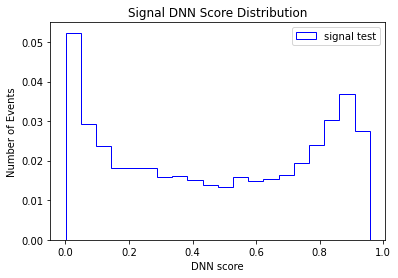

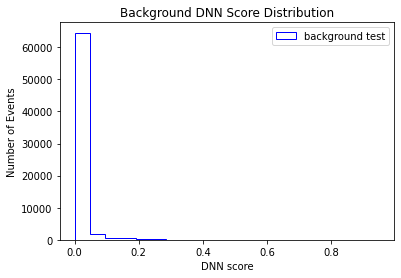

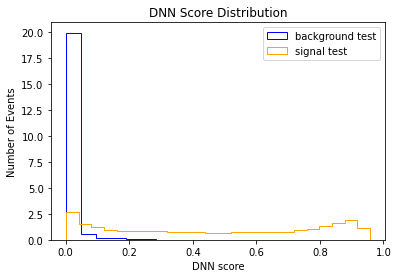

In [18]:
# Plot DNN score distribution

bgd = y_pred[y_test == 0]
sgl = y_pred[y_test == 1]
sgl_weight = test_weight[y_test == 1].flatten()
bgd_weight = test_weight[y_test == 0].flatten()

plt.hist(sgl, color='blue', weights= sgl_weight, histtype='step', bins = 20, label= 'signal test')
plt.xlabel('DNN score')
plt.ylabel('Number of Events')
#plt.vlines(0.55, ymin=0, ymax = 0.10, color = 'orange')
plt.legend(loc = 'best')
plt.title('Signal DNN Score Distribution')
plt.savefig(fname = f'DNN_Score_Plts/full/combine_mass_sig_score_v2.png', format='png')
plt.show()

plt.hist(bgd, color='blue', weights= bgd_weight, histtype='step', bins = 20, label= 'background test')
plt.xlabel('DNN score')
plt.ylabel('Number of Events')
#plt.vlines(0.5, ymin=0, ymax = 10, color = 'orange')
plt.legend(loc = 'best')
plt.title('Background DNN Score Distribution')
plt.savefig(fname = f'DNN_Score_Plts/full/combine_mass_bkg_score_v2.png', format='png')
plt.show()

plt.hist(bgd, color='blue', weights= bgd_weight, histtype='step', bins = 20, label= 'background test', density = True)
plt.hist(sgl, color='orange', weights= sgl_weight, histtype='step', bins = 24, label= 'signal test', density = True)
plt.xlabel('DNN score')
plt.ylabel('Number of Events')
plt.legend(loc = 'best')
plt.title('DNN Score Distribution')
plt.savefig(fname = f'DNN_Score_Plts/full/combine_mass_score_v2.png', format='png')
plt.show()

In [20]:
bgd_x_all = x_all_test[y_test == 0]
bgd_y = y_pred[y_test == 0]
bgd_test = y_test[y_test == 0]

sig_x_all = x_all_test[y_test == 1]
sig_y = y_pred[y_test == 1]
sig_test = y_test[y_test == 1]

result_sig_df = pd.DataFrame(sig_x_all, columns = list(sig_df.columns))
result_sig_df[b'genweight_scale'] = result_sig_df.loc[:, b'genweight'].values * samp_weight_scale[0]
result_sig_df[b'DNN_score'] = sig_y
result_bgd_df = pd.DataFrame(bgd_x_all, columns = list(bkg_df.columns))
result_bgd_df[b'DNN_score'] = bgd_y
result_bgd_df_labsort = result_bgd_df.sort_values([b'label_num'])
bgd_scaled_weight = []
for i in range(1, len(dfs_ggHH_label)):
    df = result_bgd_df_labsort[result_bgd_df_labsort[b'label_num'] == i]
    weights = df.loc[:, b'genweight'].values * samp_weight_scale[i]
    bgd_scaled_weight += weights.tolist()
    
result_bgd_df_labsort[b'genweight_scale'] = bgd_scaled_weight

### Save to ROOT Trees

In [21]:
# Make copy of dataframe

result_sig_df_alt = pd.DataFrame()
result_bgd_df_alt = pd.DataFrame()
for column in list(result_sig_df.columns):
    result_sig_df_alt[column] = result_sig_df.loc[:, column].values
    result_bgd_df_alt[column] = result_bgd_df_labsort.loc[:, column].values

In [22]:
from ROOT import RDF
from ROOT import Internal

result_sig_dict = {key.decode("utf-8"): result_sig_df_alt[key].values for key in list(result_sig_df_alt.columns)}
result_bgd_dict = {key.decode("utf-8"): result_bgd_df_alt[key].values for key in list(result_bgd_df_alt.columns)}
sig_rdf = rt.RDF.MakeNumpyDataFrame(result_sig_dict)
bgd_rdf = rt.RDF.MakeNumpyDataFrame(result_bgd_dict)
sig_rdf.Snapshot('tree', f'DNN_Trees/combine_sequential_DNN/sig_ggHH_v2.root')
bgd_rdf.Snapshot('tree', f'DNN_Trees/combine_sequential_DNN/bgd_ggHH_v2.root')

<cppyy.gbl.ROOT.RDF.RResultPtr<ROOT::RDF::RInterface<ROOT::Detail::RDF::RLoopManager,void> > object at 0xb01e2b70>

In [23]:
mc_labels = ['VBFToHH',
            'VHToGG', 'ttHToGG', 'VBFHToGG', 'GluGluHtoGG',
            'TTJets', 'TTGJets', 'TTGG_0Jets',
            'GJet_SmallPt', 'GJet_BigPt', 'DiPhotonJetsBox', 'DiPhotonJetsBox1B', 'DiPhotonJetsBox2B', 'QCDJets']
result_bgd_dfs_lst = []

for i in range(len(mc_labels)):
    samp_df = result_bgd_df_alt[result_bgd_df_alt[b'label_num'] == i+1]
    result_bgd_dfs_lst.append(samp_df)
    samp_dict = {key.decode("utf-8"): samp_df[key].values for key in list(samp_df.columns)}
    samp_rdf = rt.RDF.MakeNumpyDataFrame(samp_dict)
    samp_rdf.Snapshot('tree',f'DNN_Trees/combine_sequential_DNN/{mc_labels[i]}_ggHH_v2.root' )

In [24]:
x = 6
samp_file = uproot.open(f'DNN_Trees/combine_sequential_DNN/{mc_labels[x]}_ggHH_v2.root')
samp_array = samp_file['tree'].arrays()
samp_df = pd.DataFrame(samp_array)
samp_df.head()

,b'leading_photon_eta',b'leading_photon_phi',b'subleading_photon_eta',b'subleading_photon_phi',b'leading_bjet_pt_corr',b'leading_bjet_eta',b'leading_bjet_phi',b'subleading_bjet_pt_corr',b'subleading_bjet_eta',b'subleading_bjet_phi',...,b'nbjet',b'nphoton',b'njet',b'genweight',b'dibjet_mass_corr',b'diphoton_mass',b'event',b'label_num',b'genweight_scale',b'DNN_score'
0,0.820557,2.325684,-0.426941,-3.041016,101.634521,-1.628906,-1.242432,67.078491,-2.080566,-0.471375,...,2.0,2.0,11.0,-0.060774,78.438972,124.422455,13578721.0,7.0,-0.293258,0.012603
1,-2.235840,1.028564,-0.665527,1.745117,89.913757,-1.543945,-0.880127,38.481445,-1.642578,2.655762,...,4.0,2.0,9.0,0.060774,143.175400,117.008896,6684663.0,7.0,0.293258,0.013317
2,0.747559,-2.606445,0.818359,0.404724,73.061920,1.770020,1.543701,46.795959,1.042725,-1.147949,...,4.0,2.0,7.0,0.060774,115.269485,156.885895,10450083.0,7.0,0.293258,0.000439
3,0.612549,-2.089844,-0.940918,-1.189209,82.308838,0.402283,1.220703,54.583252,0.190887,-0.352478,...,3.0,2.0,12.0,0.060774,135.096802,105.606522,3156166.0,7.0,0.293258,0.095966
4,0.449097,-3.060059,-0.152954,-0.910034,69.703613,-1.016113,-2.300781,54.422607,-0.203735,1.272461,...,3.0,2.0,10.0,-0.031315,157.315903,153.896347,923060.0,7.0,-0.151109,0.006262


### Performance

In [5]:
# Bkg reduction
def significance_file(k):
    file.write(f'cutoff: {k}\n')
    bgd = y_pred[y_test == 0]
    file.write(f'# background: {len(bgd)}\n')
    bgd_bin = []
    for event in bgd:
        if event >= k:
            bgd_bin.append(1)
        else:
            bgd_bin.append(0)
    file.write(f'# false signal: {sum(bgd_bin)}\n')

    sgl = y_pred[y_test == 1]
    file.write(f'# signal: {len(sgl)}\n')
    sgl_bin = []
    for event in sgl:
        if event >= k:
            sgl_bin.append(1)
        else:
            sgl_bin.append(0)
    file.write(f'# true signal: {sum(sgl_bin)}\n')
    bgd_bin_np = np.array(bgd_bin)
    sgl_bin_np = np.array(sgl_bin)
    sgl_weight = result_sig_df.loc[:, b'genweight_scale'].values
    bgd_weight = result_bgd_df_labsort.loc[:, b'genweight_scale'].values
    file.write(f'original background: {np.sum(bkg_weight_np_sfl)}\n')
    file.write(f'original test background: {np.sum(bgd_weight)}\n')
    file.write(f'original signal: {np.sum(sig_weight_np_sfl)}\n')
    file.write(f'original test signal: {np.sum(sgl_weight)}\n')

    re_bkg = np.sum(bgd_bin_np * bgd_weight)
    file.write(f'remaining background: {re_bkg}\n')
    re_sig = np.sum(sgl_bin_np * sgl_weight)
    file.write(f'remaining signal: {re_sig}\n')
    file.write(f'original S/sqrt(S+B): {np.sum(sig_weight_np_sfl) / np.sqrt(np.sum(sig_weight_np_sfl) + np.sum(bkg_weight_np_sfl))}\n')
    file.write(f'original test S/sqrt(S+B): {np.sum(sgl_weight) / np.sqrt(np.sum(sgl_weight) + np.sum(bgd_weight))}\n')
    file.write(f'S/sqrt(S+B): {re_sig / np.sqrt(re_sig + re_bkg)}\n')
    file.write('\n')
    return re_sig / np.sqrt(re_sig + re_bkg)

def significance_print(k):
    print(f'cutoff: {k}')
    bgd = y_pred[y_test == 0]
    print(f'# background: {len(bgd)}\n')
    bgd_bin = []
    for event in bgd:
        if event >= k:
            bgd_bin.append(1)
        else:
            bgd_bin.append(0)
    print(f'# false signal: {sum(bgd_bin)}\n')

    bgd = y_pred[y_test == 0]
    print(f'# signal: {len(sgl)}')
    sgl_bin = []
    for event in sgl:
        if event >= k:
            sgl_bin.append(1)
        else:
            sgl_bin.append(0)
    print(f'# true signal: {sum(sgl_bin)}\n')
    bgd_bin_np = np.array(bgd_bin)
    sgl_bin_np = np.array(sgl_bin)
    sgl_weight = result_sig_df.loc[:, b'genweight_scale'].values
    bgd_weight = result_bgd_df_labsort.loc[:, b'genweight_scale'].values
    print(f'original background: {np.sum(bkg_weight_np_sfl)}')
    print(f'original test background: {np.sum(bgd_weight)}')
    print(f'original signal: {np.sum(sig_weight_np_sfl)}')
    print(f'original test signal: {np.sum(sgl_weight)}')

    re_bkg = np.sum(bgd_bin_np * bgd_weight)
    print(f'remaining background: {re_bkg}\n')
    re_sig = np.sum(sgl_bin_np * sgl_weight)
    print(f'remaining signal: {re_sig}\n')
    print(f'original S/sqrt(S+B): {np.sum(sig_weight_np_sfl) / np.sqrt(np.sum(sig_weight_np_sfl) + np.sum(bkg_weight_np_sfl))}\n')
    print(f'original test S/sqrt(S+B): {np.sum(sgl_weight) / np.sqrt(np.sum(sgl_weight) + np.sum(bgd_weight))}\n')
    print(f'S/sqrt(S+B): {re_sig / np.sqrt(re_sig + re_bkg)}\n')
    print('\n')
    return re_sig / np.sqrt(re_sig + re_bkg)

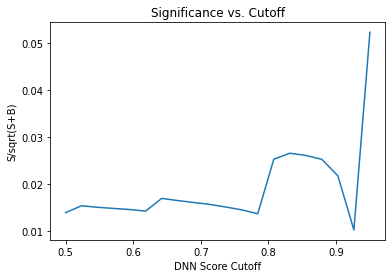

In [29]:
test_sc = np.linspace(0.5, 0.95, 20)
sc_vals = []
file = open('DNN_Score_Nums/full/combine_mass_DNN_score_v2.txt', "w")
for value in test_sc:
    sc_vals.append(significance_file(value))

file.close()
    
plt.plot(test_sc, sc_vals, label = 'combine')
plt.xlabel('DNN Score Cutoff')
plt.ylabel('S/sqrt(S+B)')
plt.title('Significance vs. Cutoff')
plt.savefig(fname = f'DNN_Score_Plts/full/combine_mass_significance_v2.png', format='png')
plt.show()

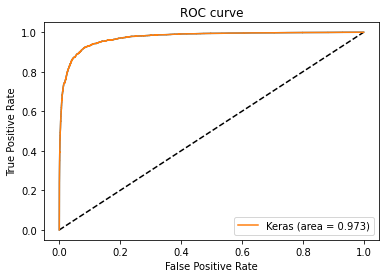

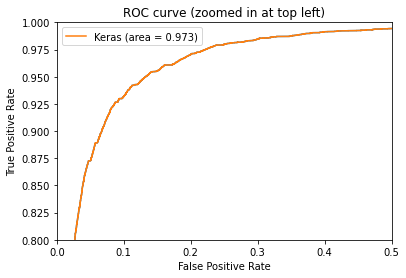

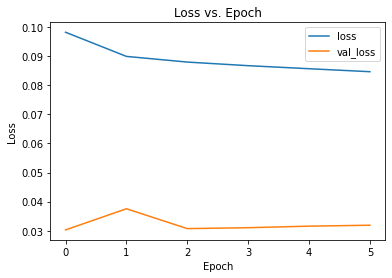

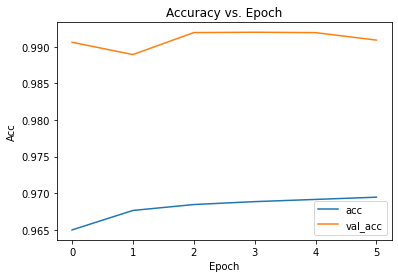

In [30]:
# Plots

# ROC curve
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras)
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.savefig(fname = f'ROC_Plts/full/combine_mass_ROC_curve_v2.png', format='png')
plt.show()

# Zoom in view of the upper left corner ROC curve
plt.figure(2)
plt.xlim(0, 0.5)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras)
plt.plot(fpr_keras, tpr_keras, label= 'Keras (area = {:.3f})'.format(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.savefig(fname = f'ROC_Plts/full/combine_mass_ROC_curve_zoom_v2.png', format='png')
plt.show()


# plot loss vs epoch
plt.figure(3)
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.legend(loc="best")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.savefig(fname = f'Epoch_Plts/full/combine_mass_loss_epoch_v2.png', format='png')
plt.show()

# plot accuracy vs epoch
plt.figure(4)
plt.plot(hist.history['accuracy'], label='acc')
plt.plot(hist.history['val_accuracy'], label='val_acc')
plt.legend(loc="best")
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.title('Accuracy vs. Epoch')
plt.savefig(fname = f'Epoch_Plts/full/combine_mass_acc_epoch_v2.png', format='png')
plt.show()

In [31]:
file = open('Efficiency/full/combine_mass_DNN_efficiency_v2.txt', "w")
file.write('1% acceptance\n')
for x in tpr_keras[fpr_keras>=0.009997]:
    if x in tpr_keras[fpr_keras<=0.01]:
        file.write(f'{x}\n')

file.write('\n')

file.write('0.1% acceptance\n')
for y in tpr_keras[fpr_keras>=0.0009997]:
    if y in tpr_keras[fpr_keras<=0.001]:
        file.write(f'{y}\n')
file.close()

## Mass Sculpting

In [32]:
def check_mass_gg(label, test_all, var_index, weight_index, dnn_index, label_index):
    samples = ['Background', 'Signal']
    fontsize=25
    TPR_thresholds = [0.8,0.7,0.6, 0.5, 0.4, 0.3,0.2]
    bins = np.linspace(110, 140, 30)
    plt.figure(figsize=(9,6))
    plt.hist(test_all[:,var_index][test_all[:,label_index]==label], bins=bins, weights=test_all[:,weight_index][test_all[:,label_index]==label], density=True, label='No cut')
    for TPR_threshold in TPR_thresholds:
        #print(TPR_threshold)
    
        tmp = test_all[np.where((test_all[:,label_index]==label)*(test_all[:,dnn_index]>TPR_threshold))]
        plt.hist(tmp[:,var_index],
             bins=bins, histtype='step', 
             weights=tmp[:,weight_index], 
             label= "{:.0f}% bkg eff".format(100*TPR_threshold),
             density=True)
    
    plt.legend(loc='best')
    plt.ylabel(samples[label] + ' events (normalized to unit area)',fontsize=16)
    plt.xlabel(r'$m_{\gamma\gamma}$',fontsize=fontsize)
    plt.title(samples[label])
    plt.savefig(fname = f'Mass_Sculpt_Plts/full/combine_mass_gg_mass_sculpt_{samples[label]}_v2.png', format = 'png')
    
def check_mass_jj(label, test_all, var_index, weight_index, dnn_index, label_index):
    samples = ['Background', 'Signal']
    fontsize=25
    TPR_thresholds = [0.8,0.7,0.6, 0.5, 0.4, 0.3,0.2]
    bins = np.linspace(110, 140, 30)
    plt.figure(figsize=(9,6))
    plt.hist(test_all[:,var_index][test_all[:,label_index]==label], bins=bins, weights=test_all[:,weight_index][test_all[:,label_index]==label], density=True, label='No cut')
    for TPR_threshold in TPR_thresholds:
        #print(TPR_threshold)
    
        tmp = test_all[np.where((test_all[:,label_index]==label)*(test_all[:,dnn_index]>TPR_threshold))]
        plt.hist(tmp[:,var_index],
             bins=bins, histtype='step', 
             weights=tmp[:,weight_index], 
             label= "{:.0f}% bkg eff".format(100*TPR_threshold),
             density=True)
    
    plt.legend(loc='best')
    plt.ylabel(samples[label] + ' events (normalized to unit area)',fontsize=16)
    plt.xlabel(r'$m_{jj}$',fontsize=fontsize)
    plt.title(samples[label])
    plt.savefig(fname = f'Mass_Sculpt_Plts/full/combine_mass_jj_mass_sculpt_{samples[label]}_v2.png', format = 'png')

In [33]:
def check_mass_gg_full(label, test_all, var_index, weight_index, dnn_index, label_index):
    samples = ['Background', 'Signal']
    fontsize=25
    TPR_thresholds = [0.8,0.7,0.6, 0.5, 0.4, 0.3,0.2]
    bins = np.linspace(100, 180, 20)
    plt.figure(figsize=(9,6))
    plt.hist(test_all[:,var_index][test_all[:,label_index]==label], bins=bins, weights=test_all[:,weight_index][test_all[:,label_index]==label], density=True, label='No cut')
    for TPR_threshold in TPR_thresholds:
        #print(TPR_threshold)
    
        tmp = test_all[np.where((test_all[:,label_index]==label)*(test_all[:,dnn_index]>TPR_threshold))]
        plt.hist(tmp[:,var_index],
             bins=bins, histtype='step', 
             weights=tmp[:,weight_index], 
             label= "{:.0f}% bkg eff".format(100*TPR_threshold),
             density=True)
    
    plt.legend(loc='best')
    plt.ylabel(samples[label] + ' events (normalized to unit area)',fontsize=16)
    plt.xlabel(r'$m_{\gamma\gamma}$',fontsize=fontsize)
    plt.title(samples[label])
    plt.savefig(fname = f'Mass_Sculpt_Plts/full/combine_mass_gg_mass_sculpt_{samples[label]}_fr_v2.png', format = 'png')
    
def check_mass_jj_full(label, test_all, var_index, weight_index, dnn_index, label_index):
    samples = ['Background', 'Signal']
    fontsize=25
    TPR_thresholds = [0.8,0.7,0.6, 0.5, 0.4, 0.3,0.2]
    bins = np.linspace(70, 190, 20)
    plt.figure(figsize=(9,6))
    plt.hist(test_all[:,var_index][test_all[:,label_index]==label], bins=bins, weights=test_all[:,weight_index][test_all[:,label_index]==label], density=True, label='No cut')
    for TPR_threshold in TPR_thresholds:
        #print(TPR_threshold)
    
        tmp = test_all[np.where((test_all[:,label_index]==label)*(test_all[:,dnn_index]>TPR_threshold))]
        plt.hist(tmp[:,var_index],
             bins=bins, histtype='step', 
             weights=tmp[:,weight_index], 
             label= "{:.0f}% bkg eff".format(100*TPR_threshold),
             density=True)
    
    plt.legend(loc='best')
    plt.ylabel(samples[label] + ' events (normalized to unit area)',fontsize=16)
    plt.xlabel(r'$m_{jj}$',fontsize=fontsize)
    plt.title(samples[label])
    plt.savefig(fname = f'Mass_Sculpt_Plts/full/combine_mass_jj_mass_sculpt_{samples[label]}_fr_v2.png', format = 'png')

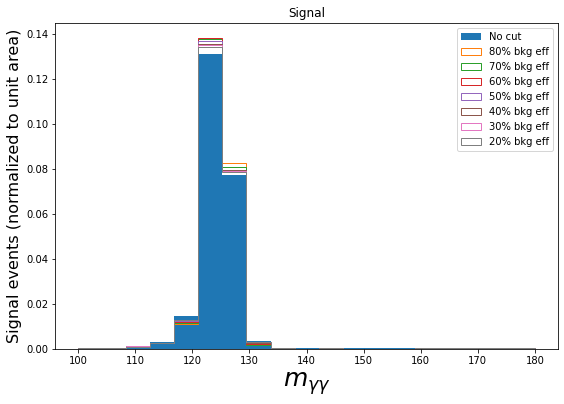

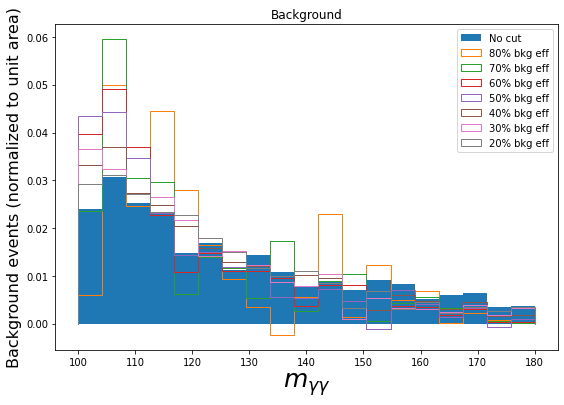

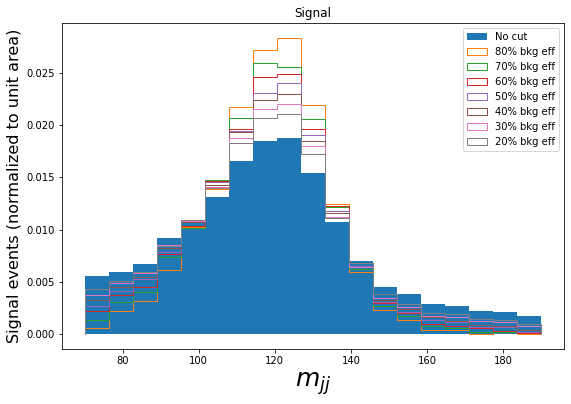

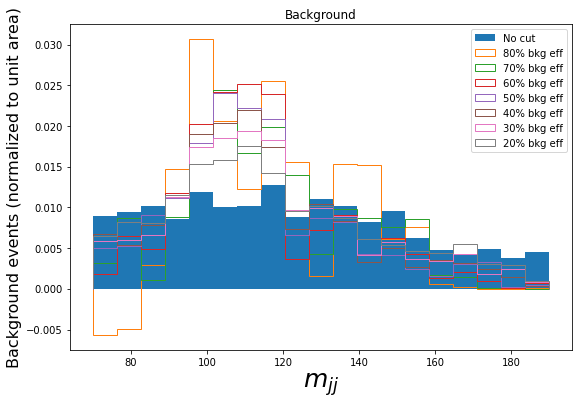

In [34]:
label_test = np.array([y_test]).T
test_all = np.concatenate((x_all_test,y_pred2, label_test), 1)
#signal
check_mass_gg_full(1, test_all, 29, 27, 32, 33)
#bkg
check_mass_gg_full(0, test_all, 29, 27, 32, 33)

#signal
check_mass_jj_full(1, test_all, 28, 27, 32, 33)
#bkg
check_mass_jj_full(0, test_all, 28, 27, 32, 33)

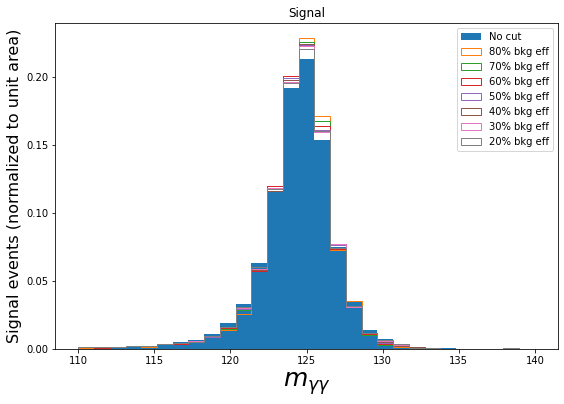

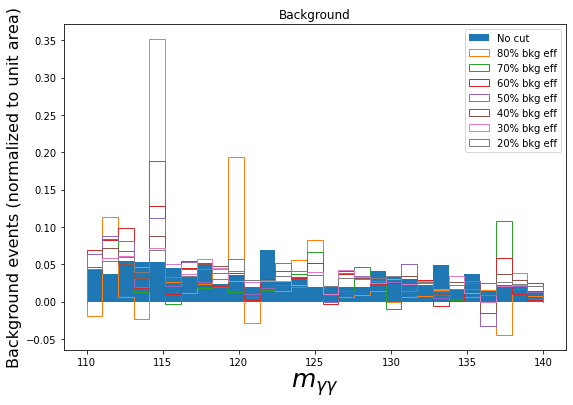

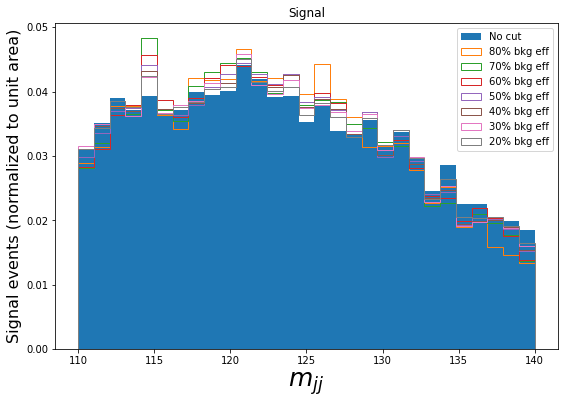

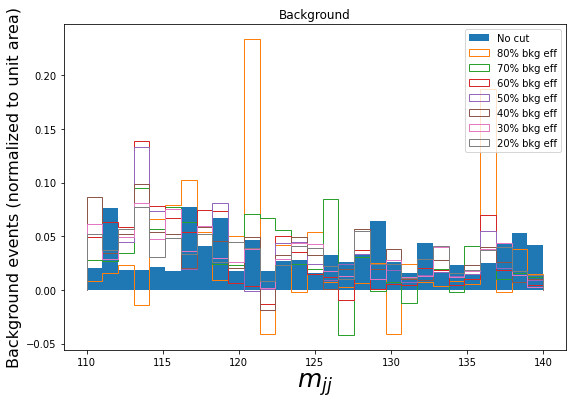

In [35]:
label_test = np.array([y_test]).T
test_all = np.concatenate((x_all_test,y_pred2, label_test), 1)
#signal
check_mass_gg(1, test_all, 29, 27, 32, 33)
#bkg
check_mass_gg(0, test_all, 29, 27, 32, 33)

#signal
check_mass_jj(1, test_all, 28, 27, 32, 33)
#bkg
check_mass_jj(0, test_all, 28, 27, 32, 33)

In [36]:
# addressing mass sculpting 
def mass_DNN_score(df, FPR_cut, mass_min, mass_max):
    df_range_1 = df[df[b'diphoton_mass'] < mass_max]
    df_range = df_range_1[df_range_1[b'diphoton_mass'] >= mass_min]
    df_values = df_range.sort_values(by = [b'DNN_score'])
    weight_array = df_values.loc[:, b'genweight'].values
    DNN_score_array = df_values.loc[:, b'DNN_score'].values
    total_weight = np.sum(weight_array)
    tn_percent = 1 - FPR_cut
    tn_weight = total_weight * tn_percent
    weight_sum = 0
    for i in range(weight_array.shape[0]):
        weight_sum += weight_array[i]
        if weight_sum >= tn_weight:
            return DNN_score_array[i]
    return DNN_score_array[-1]
        
def DNN_cuts(bins, df, FPR):
    DNN_cuts = []
    for i in range(bins.shape[0] - 1):
        DNN_cuts.append(mass_DNN_score(df, FPR / 100, bins[i], bins[i+1]))
    return DNN_cuts

def DNN_cut_pass(bins, df, DNN_cuts):
    df_cuts = []
    df_sort = df.sort_values(by = [b'diphoton_mass'])
    for i in range(bins.shape[0] - 1):
        mass_min = bins[i]
        mass_max = bins[i+1]
        df_mass_1 = df_sort[df_sort[b'diphoton_mass'] < mass_max]
        df_mass = df_mass_1[df_mass_1[b'diphoton_mass'] >= mass_min]
        DNN_scores = df_mass.loc[:, b'DNN_score'].values
        for j in range(DNN_scores.shape[0]):
            if DNN_scores[j] >= DNN_cuts[i]:
                df_cuts.append(1)
            else:
                df_cuts.append(0)
    return df_cuts


def plot_mass_sculpt_w_cut(df_sort, mass_bins, samp_name, FPR, key_name):
    ori_mass = df_sort.loc[:, b'diphoton_mass'].values
    ori_weight = df_sort.loc[:, b'genweight'].values
    cut_df = df_sort[df_sort[key_name] == 1]
    cut_mass = cut_df.loc[:, b'diphoton_mass'].values
    cut_weight = cut_df.loc[:, b'genweight'].values
    plt.figure()
    plt.hist(ori_mass, bins = mass_bins, weights = ori_weight, label = 'uncut', density = True)
    plt.hist(cut_mass, bins = mass_bins, range=(100, 180), weights = cut_weight, histtype='step', label = 'cut', density = True )
    plt.legend(loc = 'best')
    plt.xlabel('Diphoton Mass')
    plt.ylabel('Number of Events')
    plt.title(f'{samp_name} Distribution')
    plt.savefig(fname = f'Mass_Sculpt_Plts/full/combine_mgg_{samp_name}_cut_{FPR}_v2.png', format = 'png')
    plt.show()

In [2]:
# for when drawing from saved tree

# samp_file_1 = uproot.open(f'DNN_Trees/combine_sequential_DNN/bgd_combine_seqDNN.root')
# samp_array_1 = samp_file_1['tree'].arrays()
# result_bgd_df_saved = pd.DataFrame(samp_array_1)

# samp_file_2 = uproot.open(f'DNN_Trees/combine_sequential_DNN/sig_combine_seqDNN.root')
# samp_array_2 = samp_file_2['tree'].arrays()
# result_sig_df_saved = pd.DataFrame(samp_array_2)

# result_bgd_df_sort = result_bgd_df_saved.sort_values(by = [b'diphoton_mass'])
# result_sig_df_sort = result_sig_df_saved.sort_values(by = [b'diphoton_mass'])

In [37]:
result_bgd_df_sort = result_bgd_df_alt.sort_values(by = [b'diphoton_mass'])
result_sig_df_sort = result_sig_df_alt.sort_values(by = [b'diphoton_mass'])

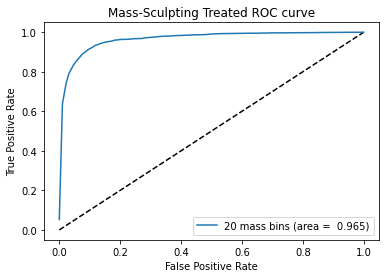

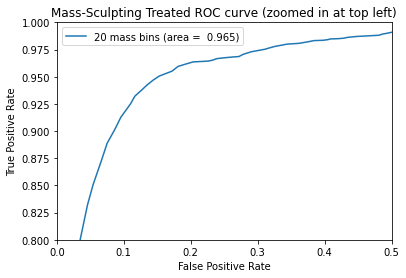

In [38]:
# ROC curve post ms with less bins
fprs = np.linspace(0, 100, 101)
bins = np.linspace(100, 180, 21)
result_fpr = []
result_tpr = []
for fpr in fprs:
    DNN_sc_cuts = DNN_cuts(bins, result_bgd_df_sort, fpr)
    bgd_cuts = np.array(DNN_cut_pass(bins, result_bgd_df_sort, DNN_sc_cuts))
    sig_cuts = np.array(DNN_cut_pass(bins, result_sig_df_sort, DNN_sc_cuts))
    bgd_weights = result_bgd_df_sort.loc[:, b'genweight']
    sig_weights = result_sig_df_sort.loc[:, b'genweight']
    new_fpr = np.sum(bgd_cuts * bgd_weights) / np.sum(bgd_weights)
    new_tpr = np.sum(sig_cuts * sig_weights) / np.sum(sig_weights)
    result_fpr.append(new_fpr)
    result_tpr.append(new_tpr)

# ROC curve

auc = np.trapz(result_tpr, x = result_fpr)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(result_fpr, result_tpr, label='20 mass bins (area =  {:.3f})'.format(auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Mass-Sculpting Treated ROC curve')
plt.legend(loc='best')
plt.savefig(fname = f'ROC_Plts/full/postms_ROC_curve_sm_weight_v2.png', format='png')
plt.show()

# Zoom in view of the upper left corner ROC curve
plt.figure(2)
plt.xlim(0, 0.5)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(result_fpr, result_tpr, label= '20 mass bins (area =  {:.3f})'.format(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Mass-Sculpting Treated ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.savefig(fname = f'ROC_Plts/full/postms_ROC_curve_zoom_sm_weight_v2.png', format = 'png')
plt.show()

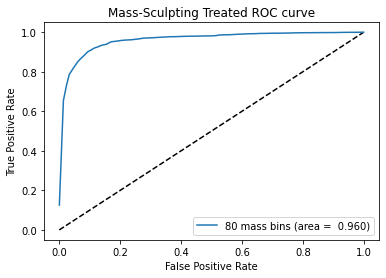

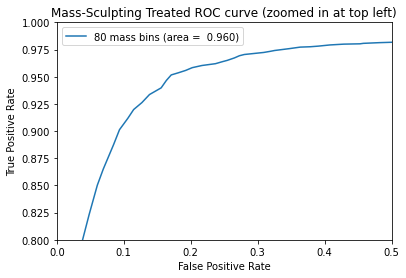

In [39]:
# ROC curve post ms with more bins
fprs = np.linspace(0, 100, 101)
bins = np.linspace(100, 180, 81)
result_fpr = []
result_tpr = []
for fpr in fprs:
    DNN_sc_cuts = DNN_cuts(bins, result_bgd_df_sort, fpr)
    bgd_cuts = np.array(DNN_cut_pass(bins, result_bgd_df_sort, DNN_sc_cuts))
    sig_cuts = np.array(DNN_cut_pass(bins, result_sig_df_sort, DNN_sc_cuts))
    bgd_weights = result_bgd_df_sort.loc[:, b'genweight']
    sig_weights = result_sig_df_sort.loc[:, b'genweight']
    new_fpr = np.sum(bgd_cuts * bgd_weights) / np.sum(bgd_weights)
    new_tpr = np.sum(sig_cuts * sig_weights) / np.sum(sig_weights)
    result_fpr.append(new_fpr)
    result_tpr.append(new_tpr)

# ROC curve

auc = np.trapz(result_tpr, x = result_fpr)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(result_fpr, result_tpr, label='80 mass bins (area =  {:.3f})'.format(auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Mass-Sculpting Treated ROC curve')
plt.legend(loc='best')
plt.savefig(fname = f'ROC_Plts/full/postms_ROC_curve_weight_v2.png', format='png')
plt.show()

# Zoom in view of the upper left corner ROC curve
plt.figure(2)
plt.xlim(0, 0.5)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(result_fpr, result_tpr, label= '80 mass bins (area =  {:.3f})'.format(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Mass-Sculpting Treated ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.savefig(fname = f'ROC_Plts/full/postms_ROC_curve_zoom_weight_v2.png', format = 'png')
plt.show()

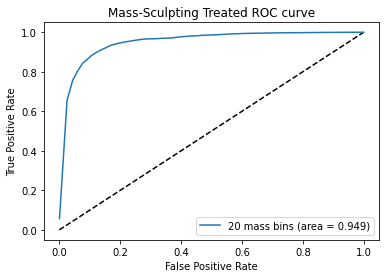

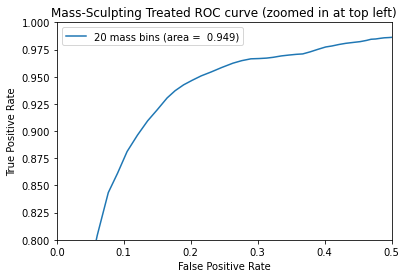

In [40]:
# ROC curve post ms with less bins
fprs = np.linspace(0, 100, 101)
bins = np.linspace(100, 180, 21)
result_fpr = []
result_tpr = []
for fpr in fprs:
    DNN_sc_cuts = DNN_cuts(bins, result_bgd_df_sort, fpr)
    bgd_cuts = DNN_cut_pass(bins, result_bgd_df_sort, DNN_sc_cuts)
    sig_cuts = DNN_cut_pass(bins, result_sig_df_sort, DNN_sc_cuts)
    new_fpr = bgd_cuts.count(1) / len(bgd_cuts)
    new_tpr = sig_cuts.count(1) / len(sig_cuts)
    result_fpr.append(new_fpr)
    result_tpr.append(new_tpr)

# ROC curve

auc = np.trapz(result_tpr, x = result_fpr)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(result_fpr, result_tpr, label='20 mass bins (area = {:.3f})'.format(auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Mass-Sculpting Treated ROC curve')
plt.legend(loc='best')
plt.savefig(fname = f'ROC_Plts/full/postms_ROC_curve_sm_v2.png', format='png')
plt.show()

# Zoom in view of the upper left corner ROC curve
plt.figure(2)
plt.xlim(0, 0.5)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(result_fpr, result_tpr, label= '20 mass bins (area =  {:.3f})'.format(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Mass-Sculpting Treated ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.savefig(fname = f'ROC_Plts/full/postms_ROC_curve_zoom_sm_v2.png', format = 'png')
plt.show()

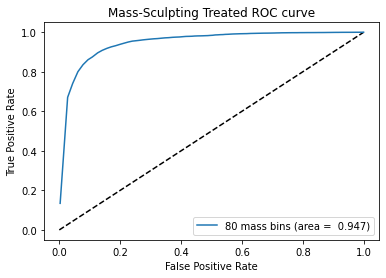

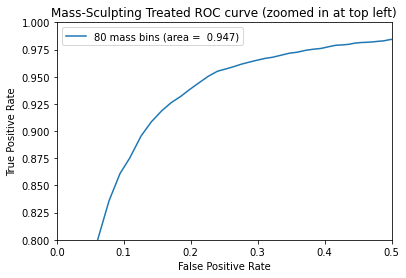

In [41]:
# ROC curve post ms with more bins
fprs = np.linspace(0, 100, 101)
bins = np.linspace(100, 180, 81)
result_fpr = []
result_tpr = []
for fpr in fprs:
    DNN_sc_cuts = DNN_cuts(bins, result_bgd_df_sort, fpr)
    bgd_cuts = DNN_cut_pass(bins, result_bgd_df_sort, DNN_sc_cuts)
    sig_cuts = DNN_cut_pass(bins, result_sig_df_sort, DNN_sc_cuts)
    new_fpr = bgd_cuts.count(1) / len(bgd_cuts)
    new_tpr = sig_cuts.count(1) / len(sig_cuts)
    result_fpr.append(new_fpr)
    result_tpr.append(new_tpr)

# ROC curve

auc = np.trapz(result_tpr, x = result_fpr)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(result_fpr, result_tpr, label='80 mass bins (area =  {:.3f})'.format(auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Mass-Sculpting Treated ROC curve')
plt.legend(loc='best')
plt.savefig(fname = f'ROC_Plts/full/postms_ROC_curve_v2.png', format='png')
plt.show()

# Zoom in view of the upper left corner ROC curve
plt.figure(2)
plt.xlim(0, 0.5)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(result_fpr, result_tpr, label= '80 mass bins (area =  {:.3f})'.format(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Mass-Sculpting Treated ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.savefig(fname = f'ROC_Plts/full/postms_ROC_curve_zoom_v2.png', format = 'png')
plt.show()

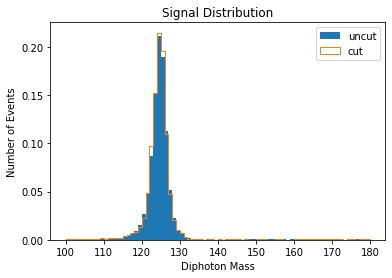

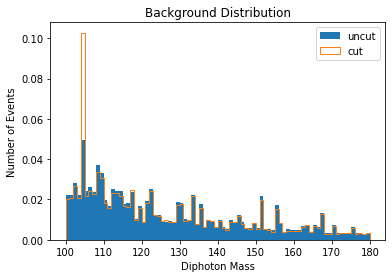

In [43]:
bins = np.linspace(100, 180, 81)
FPR = 3
DNN_sc_cuts = DNN_cuts(bins, result_bgd_df, FPR)
result_bgd_df_sort[b'mass_sculpt_cut'] = DNN_cut_pass(bins, result_bgd_df_sort, DNN_sc_cuts)
result_sig_df_sort[b'mass_sculpt_cut'] = DNN_cut_pass(bins, result_sig_df_sort, DNN_sc_cuts)
plot_mass_sculpt_w_cut(result_sig_df_sort, bins, 'Signal', FPR, b'mass_sculpt_cut')
plot_mass_sculpt_w_cut(result_bgd_df_sort, bins, 'Background', FPR, b'mass_sculpt_cut')

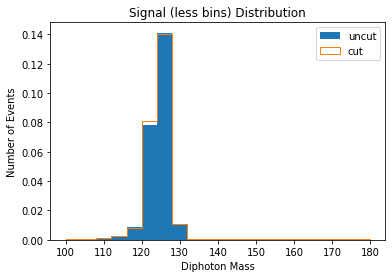

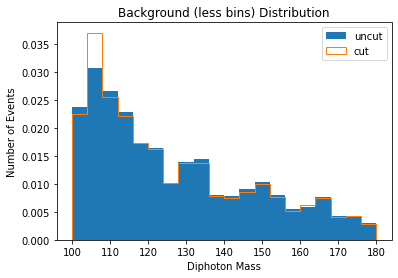

In [44]:
bins = np.linspace(100, 180, 21)
FPR = 3
DNN_sc_cuts = DNN_cuts(bins, result_bgd_df, FPR)
result_bgd_df_sort[b'mass_sculpt_cut_sm'] = DNN_cut_pass(bins, result_bgd_df_sort, DNN_sc_cuts)
result_sig_df_sort[b'mass_sculpt_cut_sm'] = DNN_cut_pass(bins, result_sig_df_sort, DNN_sc_cuts)
plot_mass_sculpt_w_cut(result_sig_df_sort, bins, 'Signal (less bins)', FPR, b'mass_sculpt_cut_sm')
plot_mass_sculpt_w_cut(result_bgd_df_sort, bins, 'Background (less bins)', FPR, b'mass_sculpt_cut_sm')

In [45]:
# Save to trees

result_sig_dict_ms = {key.decode("utf-8"): result_sig_df_sort[key].values for key in list(result_sig_df_sort.columns)}
result_bgd_dict_ms = {key.decode("utf-8"): result_bgd_df_sort[key].values for key in list(result_bgd_df_sort.columns)}
sig_rdf_ms = rt.RDF.MakeNumpyDataFrame(result_sig_dict_ms)
bgd_rdf_ms = rt.RDF.MakeNumpyDataFrame(result_bgd_dict_ms)
sig_rdf_ms.Snapshot('tree', f'DNN_Trees/combine_sequential_DNN/post_ms/sig_{FPR}_v2.root')
bgd_rdf_ms.Snapshot('tree', f'DNN_Trees/combine_sequential_DNN/post_ms/bgd_{FPR}_v2.root')

mc_labels = ['VBFToHH',
            'VHToGG', 'ttHToGG', 'VBFHToGG', 'GluGluHtoGG',
            'TTJets', 'TTGJets', 'TTGG_0Jets',
            'GJet_SmallPt', 'GJet_BigPt', 'DiPhotonJetsBox', 'DiPhotonJetsBox1B', 'DiPhotonJetsBox2B', 'QCDJets']

# individual background trees
for i in range(len(mc_labels)):
    samp_df = result_bgd_df_sort[result_bgd_df_sort[b'label_num'] == i+1]
    samp_dict = {key.decode("utf-8"): samp_df[key].values for key in list(samp_df.columns)}
    samp_rdf = rt.RDF.MakeNumpyDataFrame(samp_dict)
    samp_rdf.Snapshot('tree',f'DNN_Trees/combine_sequential_DNN/post_ms/{mc_labels[i]}_{FPR}_v2.root')

    
# nonresonant background
nonres_bgd_dfs = []
for i in range(5, len(mc_labels)):
    samp_df = result_bgd_df_sort[result_bgd_df_sort[b'label_num'] == i+1]
    nonres_bgd_dfs.append(samp_df)
nonres_bgd_df = pd.concat(nonres_bgd_dfs, ignore_index=True)
nonres_dict = {key.decode("utf-8"): nonres_bgd_df[key].values for key in list(nonres_bgd_df.columns)}
nonres_rdf = rt.RDF.MakeNumpyDataFrame(nonres_dict)
nonres_rdf.Snapshot('tree',f'DNN_Trees/combine_sequential_DNN/post_ms/nonres_{FPR}_v2.root')

<cppyy.gbl.ROOT.RDF.RResultPtr<ROOT::RDF::RInterface<ROOT::Detail::RDF::RLoopManager,void> > object at 0xd6e62740>

In [46]:
resonant_bgds = []
for i in range(5):
    resonant_bgds.append(result_bgd_dfs_lst[i])
nonresonant_bgds = []
for i in range(5, len(result_bgd_dfs_lst)):
    nonresonant_bgds.append(result_bgd_dfs_lst[i])
resonant_bgd_df = pd.concat(resonant_bgds, ignore_index = True)
resonant_bgd_df_sort = resonant_bgd_df.sort_values(by = [b'diphoton_mass'])
nonresonant_bgd_df = pd.concat(nonresonant_bgds, ignore_index=True)
nonresonant_bgd_df_sort = nonresonant_bgd_df.sort_values(by = [b'diphoton_mass'])

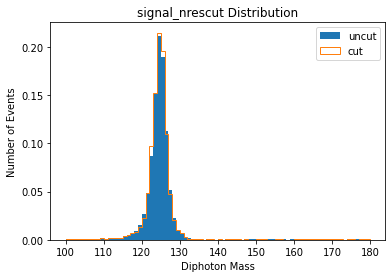

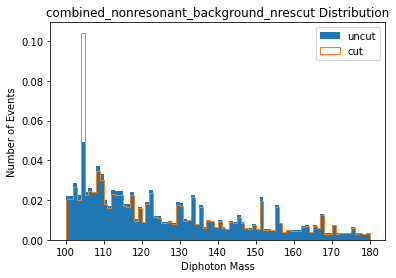

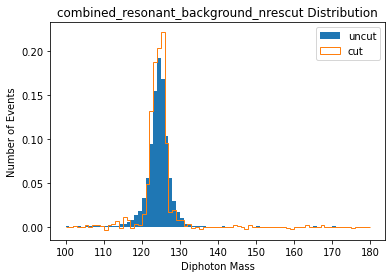

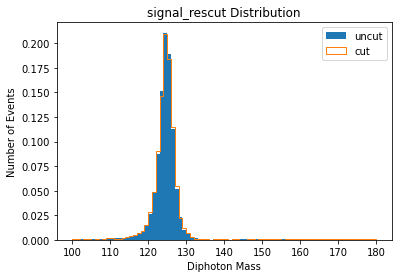

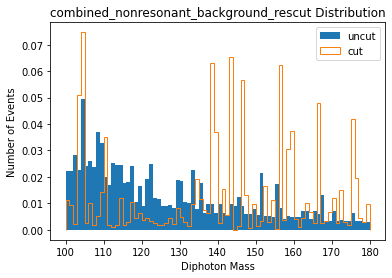

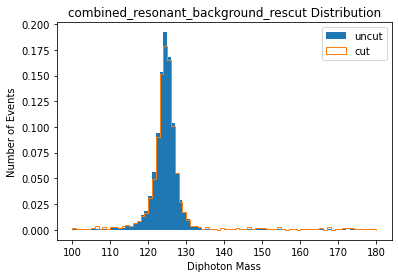

In [47]:
bins = np.linspace(100, 180, 81)
FPR = 3
DNN_sc_cuts_nres = DNN_cuts(bins, nonresonant_bgd_df_sort, FPR)
result_sig_df_sort = result_sig_df.sort_values(by = [b'diphoton_mass'])
nonresonant_bgd_df_sort[b'mass_sculpt_nrescut'] = DNN_cut_pass(bins, nonresonant_bgd_df_sort, DNN_sc_cuts_nres)
resonant_bgd_df_sort[b'mass_sculpt_nrescut'] = DNN_cut_pass(bins, resonant_bgd_df_sort, DNN_sc_cuts_nres)
result_sig_df_sort[b'mass_sculpt_nrescut'] = DNN_cut_pass(bins, result_sig_df_sort, DNN_sc_cuts_nres)
plot_mass_sculpt_w_cut(result_sig_df_sort, bins, 'signal_nrescut', FPR, b'mass_sculpt_nrescut')
plot_mass_sculpt_w_cut(nonresonant_bgd_df_sort, bins, 'combined_nonresonant_background_nrescut', FPR, b'mass_sculpt_nrescut')
plot_mass_sculpt_w_cut(resonant_bgd_df_sort, bins, 'combined_resonant_background_nrescut', FPR, b'mass_sculpt_nrescut')


DNN_sc_cuts_res = DNN_cuts(bins, resonant_bgd_df_sort, FPR)
nonresonant_bgd_df_sort[b'mass_sculpt_rescut'] = DNN_cut_pass(bins, nonresonant_bgd_df_sort, DNN_sc_cuts_res)
resonant_bgd_df_sort[b'mass_sculpt_rescut'] = DNN_cut_pass(bins, resonant_bgd_df_sort, DNN_sc_cuts_res)
result_sig_df_sort[b'mass_sculpt_rescut'] = DNN_cut_pass(bins, result_sig_df_sort, DNN_sc_cuts_res)
plot_mass_sculpt_w_cut(result_sig_df_sort, bins, 'signal_rescut', FPR, b'mass_sculpt_rescut')
plot_mass_sculpt_w_cut(nonresonant_bgd_df_sort, bins, 'combined_nonresonant_background_rescut', FPR, b'mass_sculpt_rescut')
plot_mass_sculpt_w_cut(resonant_bgd_df_sort, bins, 'combined_resonant_background_rescut', FPR, b'mass_sculpt_rescut')

### Some Plots

In [2]:
# Looking at stuff
# for when drawing from saved tree

samp_file_1 = uproot.open(f'DNN_Trees/combine_sequential_DNN/bgd_combine_seqDNN.root')
samp_array_1 = samp_file_1['tree'].arrays()
result_bgd_df_saved = pd.DataFrame(samp_array_1)

samp_file_2 = uproot.open(f'DNN_Trees/combine_sequential_DNN/sig_combine_seqDNN.root')
samp_array_2 = samp_file_2['tree'].arrays()
result_sig_df_saved = pd.DataFrame(samp_array_2)

result_bgd_df_sort = result_bgd_df_saved.sort_values(by = [b'diphoton_mass'])
result_sig_df_sort = result_sig_df_saved.sort_values(by = [b'diphoton_mass'])

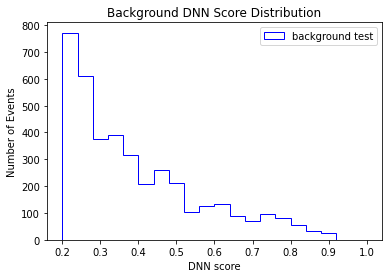

In [13]:
plt.hist(result_bgd_df_sort[b'DNN_score'], color='blue', weights= result_bgd_df_sort[b'genweight_scale'], histtype='step', bins = 20, label= 'background test', range= (0.2, 1))
plt.xlabel('DNN score')
plt.ylabel('Number of Events')
#plt.vlines(0.5, ymin=0, ymax = 10, color = 'orange')
plt.legend(loc = 'best')
plt.title('Background DNN Score Distribution')
plt.savefig(fname = f'Plots/bkd_dnn_zoom', format='png')
plt.show()

In [2]:
def saved_tree_to_df(samp_name):
    samp_file = uproot.open(f'DNN_Trees/combine_sequential_DNN/{samp_name}_combine_seqDNN.root')
    samp_array = samp_file['tree'].arrays()
    df = pd.DataFrame(samp_array)
    return df

In [3]:
labels = ['sig', 'bgd', 'VBFToHH',
            'VHToGG', 'ttHToGG', 'VBFHToGG', 'GluGluHtoGG',
            'TTJets', 'TTGJets', 'TTGG_0Jets',
            'GJet_SmallPt', 'GJet_BigPt', 'DiPhotonJetsBox', 'DiPhotonJetsBox1B', 'DiPhotonJetsBox2B', 'QCDJets']
saved_dfs = []

for label in labels:
    saved_dfs.append(saved_tree_to_df(label))

In [11]:
def ROC_curve_individual(sig_df, bkd_df, DNN_score_bins, bkg_name):
    DNN_scores = DNN_score_bins

    bkd_scores = bkd_df.loc[:, b'DNN_score'].values
    sig_scores = sig_df.loc[:, b'DNN_score'].values
    result_fpr = []
    result_tpr = []

    for score in DNN_scores:
        new_fpr = np.count_nonzero(bkd_scores >= score) / len(bkd_scores)
        new_tpr = np.count_nonzero(sig_scores >= score) / len(sig_scores)
        result_fpr.append(new_fpr)
        result_tpr.append(new_tpr)

    # ROC curve

    auc = np.trapz(result_tpr, x = result_fpr)

    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(result_fpr, result_tpr, label='20 mass bins (area = {:.3f})'.format(auc))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f' ROC curve {bkg_name}')
    plt.legend(loc='best')
    plt.savefig(fname = f'ROC_Plts/individual/ROC_{bkg_name}.png', format='png')
    #plt.show()
    plt.close()

    # Zoom in view of the upper left corner ROC curve
    plt.figure(2)
    plt.xlim(0, 0.5)
    plt.ylim(0.8, 1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(result_fpr, result_tpr, label= '20 mass bins (area =  {:.3f})'.format(auc))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title(f'ROC curve {bkg_name} (zoomed in at top left)')
    plt.legend(loc='best')
    plt.savefig(fname = f'ROC_Plts/individual/ROC_zoom_upl_{bkg_name}.png', format = 'png')
    #plt.show()
    plt.close()

    plt.figure(3)
    plt.xlim(0, 0.025)
    plt.ylim(0, 0.6)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(result_fpr, result_tpr, label= '20 mass bins (area =  {:.3f})'.format(auc))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title(f'ROC curve {bkg_name} (zoomed in at bottom)')
    plt.legend(loc='best')
    plt.savefig(fname = f'ROC_Plts/individual/ROC_zoom_bottom_{bkg_name}.png', format = 'png')
    #plt.show()
    plt.close()

In [23]:
def ROC_combined(bkd_dfs, DNN_score_bins, bkg_names):
    DNN_scores = DNN_score_bins
    tprs = []
    fprs = []
    aucs = []
    for i in range(1, len(bkd_dfs)):
        bkd_scores = bkd_dfs[i].loc[:, b'DNN_score'].values
        sig_scores = bkd_dfs[0].loc[:, b'DNN_score'].values
        result_fpr = []
        result_tpr = []

        for score in DNN_scores:
            new_fpr = np.count_nonzero(bkd_scores >= score) / len(bkd_scores)
            new_tpr = np.count_nonzero(sig_scores >= score) / len(sig_scores)
            result_fpr.append(new_fpr)
            result_tpr.append(new_tpr)

        # ROC curve

        auc = np.trapz(result_tpr, x = result_fpr)
        tprs.append(result_tpr)
        fprs.append(result_fpr)
        aucs.append(auc)
        
    colors = ['limegreen', 'cyan',
         'red', 'blue', 'magenta', 'darkorange', 
          'goldenrod', 'olive', 'seagreen', 
          'steelblue', 'forestgreen', 'navy', 'purple', 'indigo', 'pink']

    plt.figure(1, figsize = (18, 12))
    plt.plot([0, 1], [0, 1], 'k--')
    for i in range(1, len(bkd_dfs)):
        plt.plot(fprs[i-1], tprs[i-1], label=f'{bkg_names[i]}; auc = {aucs[i-1]}', color = colors[i-1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f' ROC curve')
    plt.legend(loc='best')
    plt.savefig(fname = f'ROC_Plts/ROC_curveoverlaid.png', format='png')
    plt.show()
    #plt.close()

    # Zoom in view of the upper left corner ROC curve
    plt.figure(2, figsize = (18, 12))
    plt.xlim(0, 0.5)
    plt.ylim(0.8, 1)
    plt.plot([0, 1], [0, 1], 'k--')
    for i in range(1, len(bkd_dfs)):
        plt.plot(fprs[i-1], tprs[i-1], label=f'{bkg_names[i]}; auc = {aucs[i-1]}', color = colors[i-1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title(f'ROC curve (zoomed in at top left)')
    plt.legend(loc='best')
    plt.savefig(fname = f'ROC_Plts/ROC_zoom_upl_overlaid.png', format = 'png')
    plt.show()
    #plt.close()

    plt.figure(3, figsize = (18, 12))
    plt.xlim(0, 0.025)
    plt.ylim(0, 0.6)
    plt.plot([0, 1], [0, 1], 'k--')
    for i in range(1, len(bkd_dfs)):
        plt.plot(fprs[i-1], tprs[i-1], label=f'{bkg_names[i]}; auc = {aucs[i-1]}', color = colors[i-1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title(f'ROC curve(zoomed in at bottom)')
    plt.legend(loc='best')
    plt.savefig(fname = f'ROC_Plts/ROC_zoom_bottom_overlaid.png', format = 'png')
    plt.show()
    #plt.close()
    
    plt.figure(4, figsize = (18, 12))
    plt.xlim(0, 0.005)
    plt.ylim(0, 0.6)
    plt.plot([0, 1], [0, 1], 'k--')
    for i in range(1, len(bkd_dfs)):
        plt.plot(fprs[i-1], tprs[i-1], label=f'{bkg_names[i]}; auc = {aucs[i-1]}', color = colors[i-1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title(f'ROC curve(zoomed in at bottom)')
    plt.legend(loc='best')
    plt.savefig(fname = f'ROC_Plts/ROC_zoom2_bottom_overlaid.png', format = 'png')
    plt.show()
    #plt.close()

In [25]:
bins = np.linspace(0, 1, 1001)
for i in range(1, len(labels)):
    ROC_curve_individual(saved_dfs[0], saved_dfs[i], bins, labels[i])

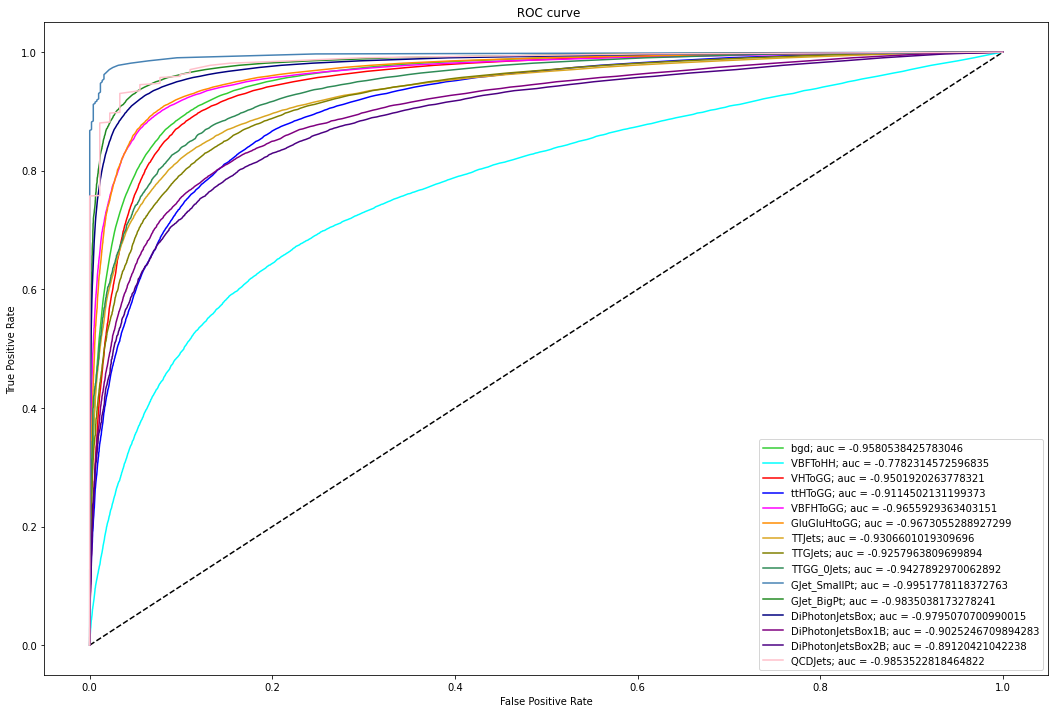

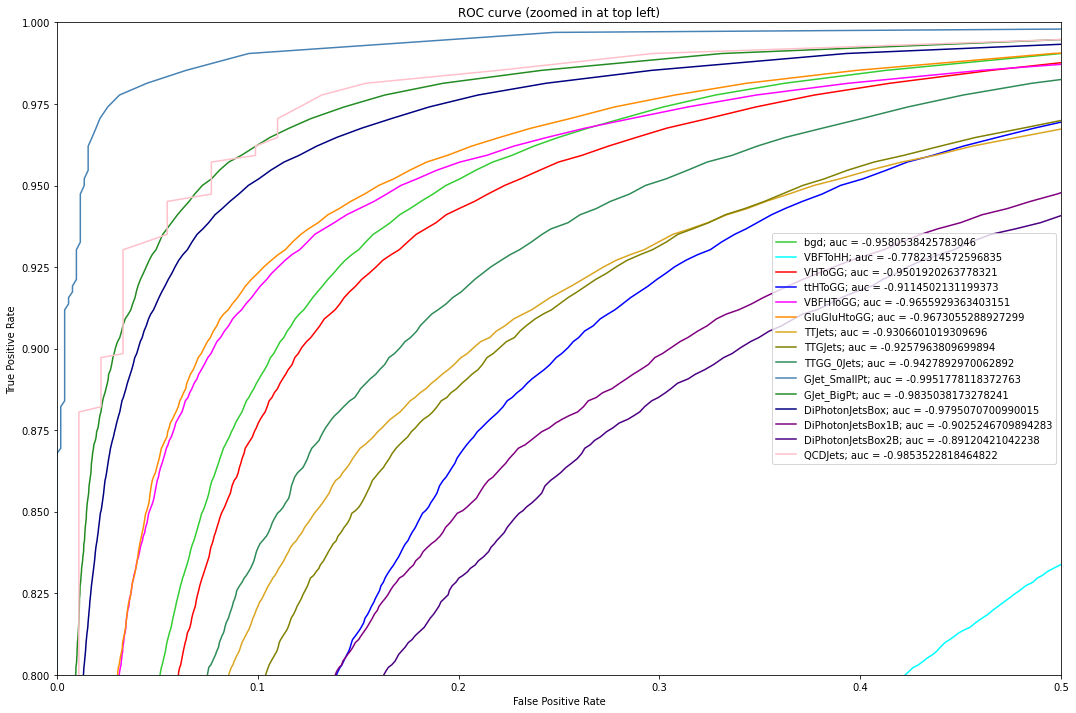

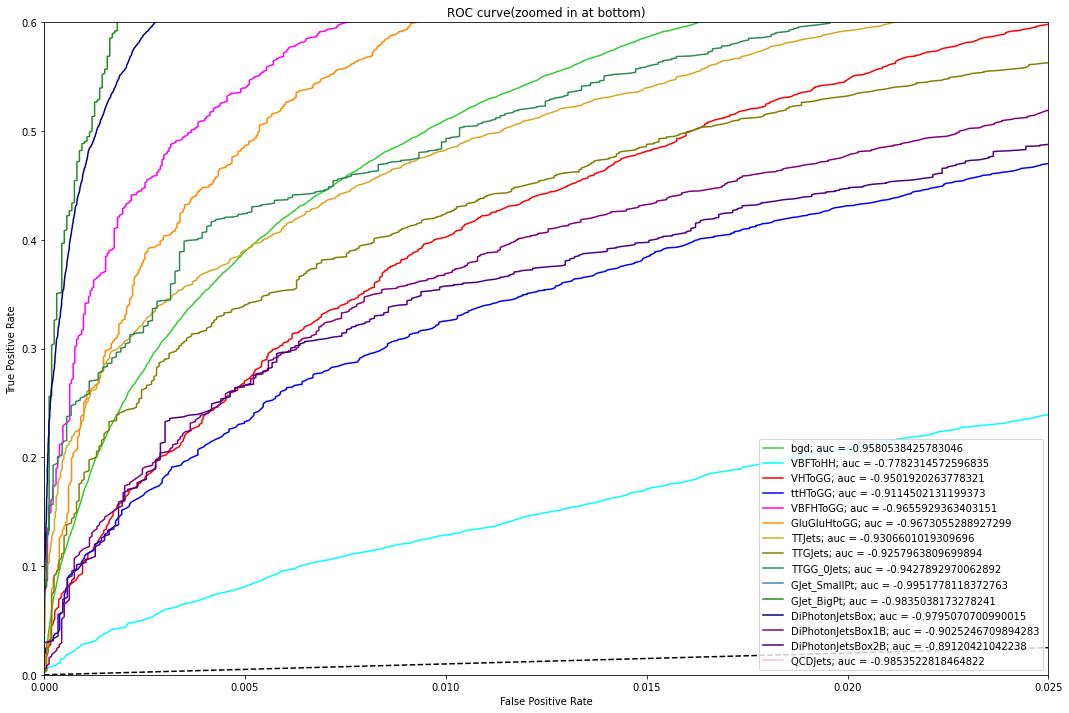

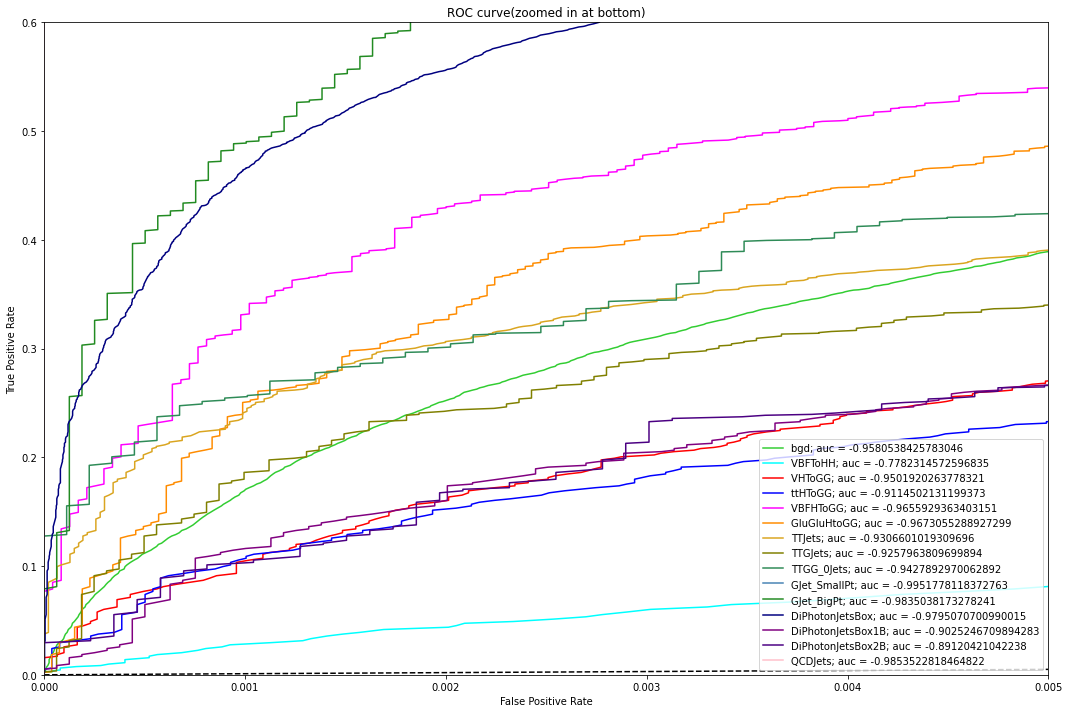

In [26]:
ROC_combined(saved_dfs, bins, labels)

/usr/local/lib64/python3.6/site-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/usr/local/lib64/python3.6/site-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


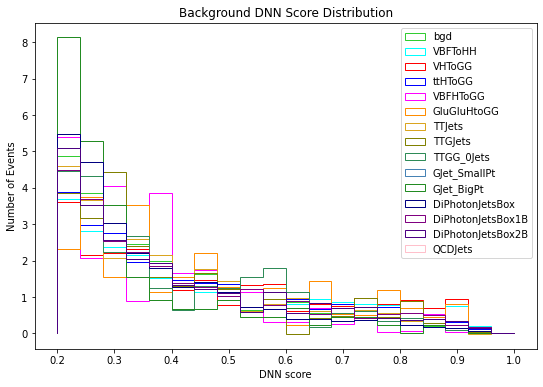

In [31]:
colors = ['limegreen', 'cyan',
         'red', 'blue', 'magenta', 'darkorange', 
          'goldenrod', 'olive', 'seagreen', 
          'steelblue', 'forestgreen', 'navy', 'purple', 'indigo', 'pink']
plt.figure(figsize = (9,6))
for i in range(1, len(saved_dfs)):
    plt.hist(saved_dfs[i][b'DNN_score'], color=colors[i-1], weights= saved_dfs[i][b'genweight_scale'], histtype='step', bins = 20, label= labels[i], range= (0.2, 1), density = True)
plt.xlabel('DNN score')
plt.ylabel('Number of Events')
#plt.vlines(0.5, ymin=0, ymax = 10, color = 'orange')
plt.legend(loc = 'best')
plt.title('Background DNN Score Distribution')
plt.savefig(fname = f'DNN_Score_Plts/bkd_dnn_zoom.png', format='png')
plt.show()

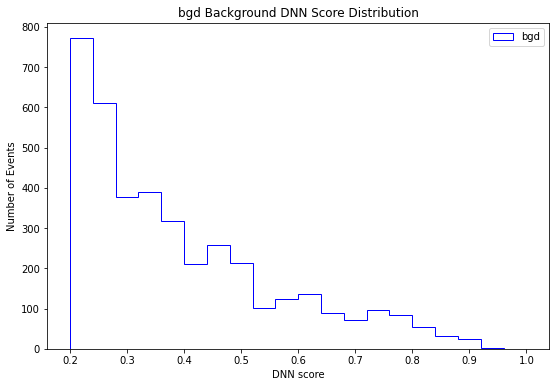

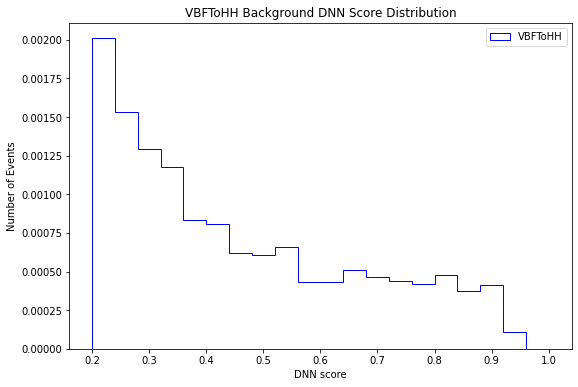

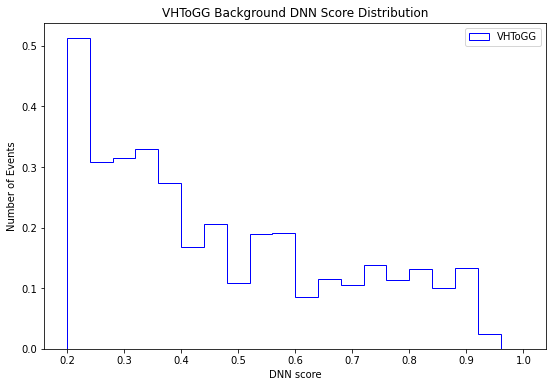

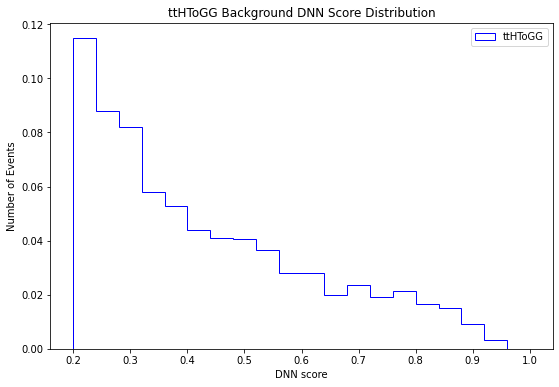

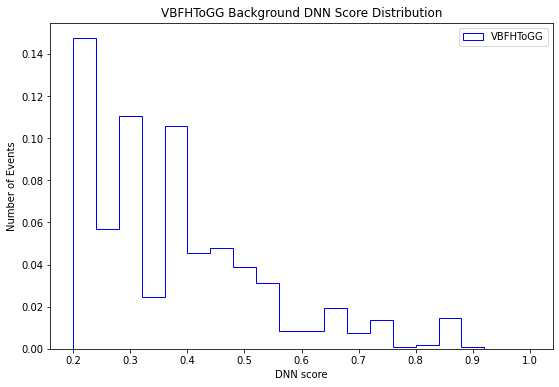

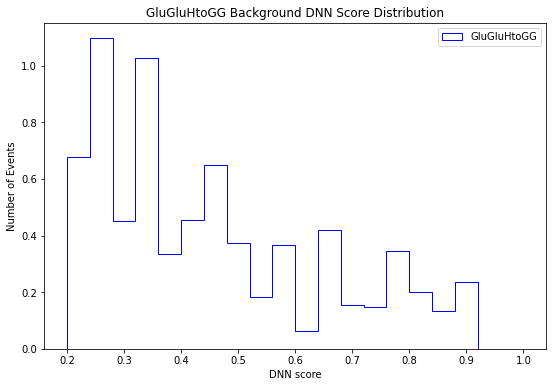

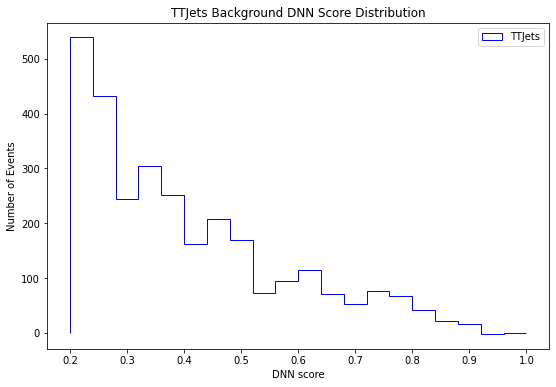

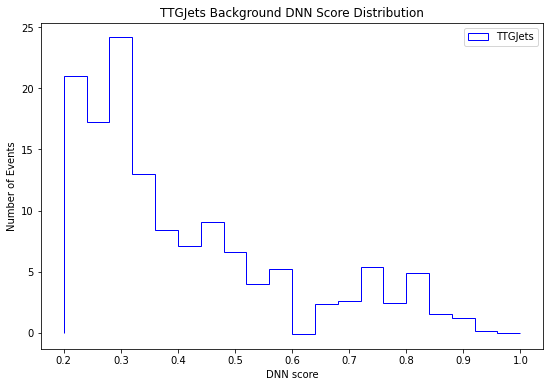

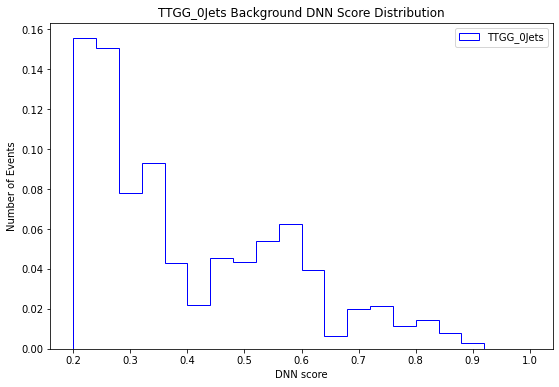

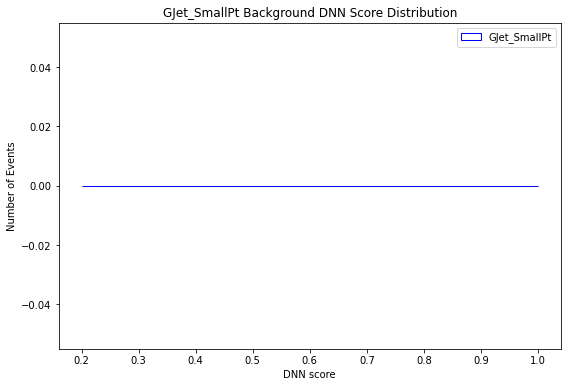

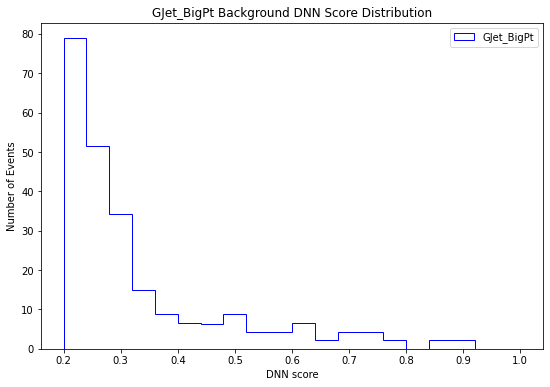

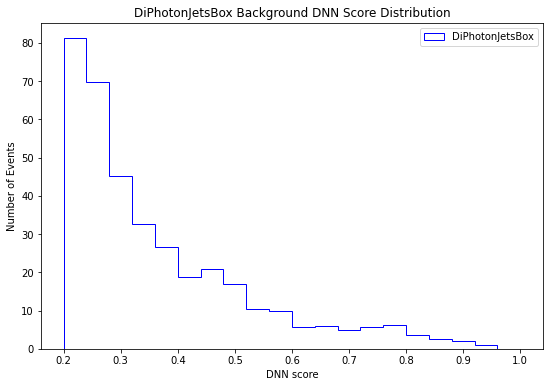

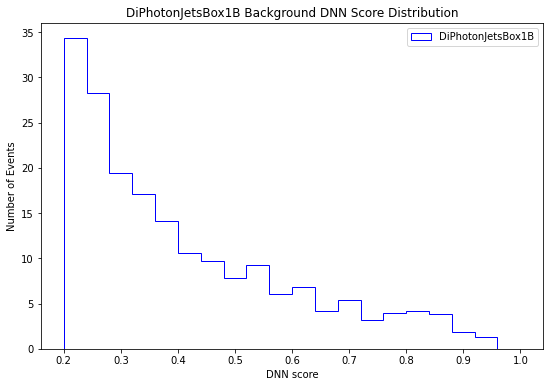

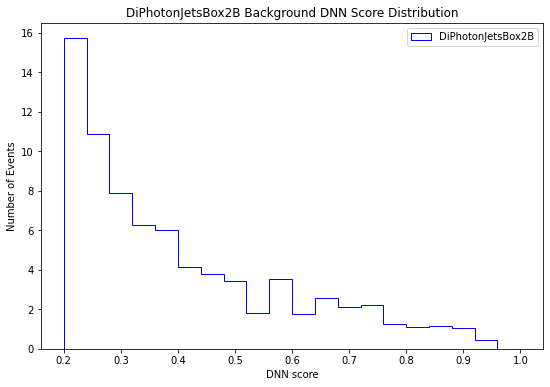

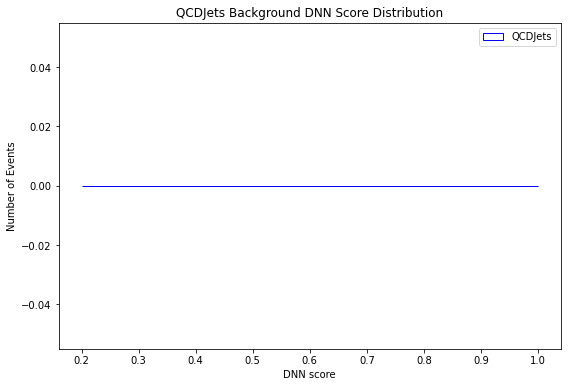

In [32]:
for i in range(1, len(saved_dfs)):
    plt.figure(figsize = (9,6))
    plt.hist(saved_dfs[i][b'DNN_score'], color='blue', weights= saved_dfs[i][b'genweight_scale'], histtype='step', bins = 20, label= labels[i], range= (0.2, 1))
    plt.xlabel('DNN score')
    plt.ylabel('Number of Events')
    #plt.vlines(0.5, ymin=0, ymax = 10, color = 'orange')
    plt.legend(loc = 'best')
    plt.title(f'{labels[i]} Background DNN Score Distribution')
    plt.savefig(fname = f'DNN_Score_Plts/bkd_{labels[i]}_dnn_zoom.png', format='png')
    plt.show()

In [14]:
print(np.count_nonzero(bkd_scores >= 0.5) / len(bkd_scores))
print(np.count_nonzero(sig_scores >= 0.5) / len(sig_scores))

print(np.count_nonzero(bkd_scores >= 0.7) / len(bkd_scores))
print(np.count_nonzero(sig_scores >= 0.7) / len(sig_scores))

0.009388367835781211
0.4977627177548981
0.0039514283338902036
0.35079716755723533


In [20]:
def significance_file(k):
    file.write(f'cutoff: {k}\n')
    file.write(f'# background: {len(bkd_scores)}\n')
    bgd_bin = np.where(bkd_scores > k, 1, 0)
    file.write(f'# false signal: {bgd_bin.count(1)}\n')
    file.write(f'# signal: {len(sig_scores)}\n')
    sgl_bin = np.where(sig_scores > k, 1, 0)
    file.write(f'# true signal: {sgl_bin.count(1)}\n')
    bgd_bin_np = np.array(bgd_bin)
    sgl_bin_np = np.array(sgl_bin)
    sgl_weight = result_sig_df_sort.loc[:, b'genweight_scale'].values
    bgd_weight = result_bgd_df_sort.loc[:, b'genweight_scale'].values
    file.write(f'original test background: {np.sum(bgd_weight)}\n')
    file.write(f'original test signal: {np.sum(sgl_weight)}\n')

    re_bkg = np.sum(bgd_bin_np * bgd_weight)
    file.write(f'remaining background: {re_bkg}\n')
    file.write(f'background efficiency weighted: {re_bkg / np.sum(bgd_weight)}\n')
    file.write(f'background efficiency unweighted: {np.count_nonzero(bkd_scores >= k) / len(bkd_scores)}\n')
    re_sig = np.sum(sgl_bin_np * sgl_weight)
    file.write(f'remaining signal: {re_sig}\n')
    file.write(f'signal efficiency weighted: {re_sig / np.sum(sgl_weight)}\n')
    file.write(f'signal efficiency unweighted: {np.count_nonzero(sig_scores >= k) / len(sig_scores)}\n')
    file.write(f'original test S/sqrt(S+B): {np.sum(sgl_weight) / np.sqrt(np.sum(sgl_weight) + np.sum(bgd_weight))}\n')
    file.write(f'S/sqrt(S+B): {re_sig / np.sqrt(re_sig + re_bkg)}\n')
    file.write('\n')
    return re_sig / np.sqrt(re_sig + re_bkg)


# Run on Data

## Load Data

In [48]:
def samp_to_df(samp_name, total_num):
    dfs = []
    for i in range(total_num+1):
        file_name = f'/storage/af/user/schen7/CMSSW_9_4_2/src/Higgs/HHbbgg/HHbbggAna/condor/output/{samp_name}{i}.root'
        samp_file = uproot.open(file_name)
        samp_array = samp_file['tree'].arrays()
        samp_df = pd.DataFrame(samp_array)
        dfs.append(samp_df)
    combine_df = pd.concat(dfs, ignore_index=True)
    return combine_df

# Data loading
def data_to_df(job_run, samp_num):
    file_name = f'/storage/af/user/schen7/CMSSW_9_4_2/src/Higgs/HHbbgg/HHbbggAna/condor/output/{job_run}/dataJob1ifile{samp_num}.root'
    data_file = uproot.open(file_name)
    data_array = data_file['tree'].arrays()
    data_df = pd.DataFrame(data_array)
    return data_df
def data_ex_to_df(job_run, samp_num):
    file_name = f'/storage/af/user/schen7/CMSSW_9_4_2/src/Higgs/HHbbgg/HHbbggAna/condor/output/{job_run}/data_exJob1ifile{samp_num}.root'
    data_file = uproot.open(file_name)
    data_array = data_file['tree'].arrays()
    data_df = pd.DataFrame(data_array)
    return data_df

In [49]:
# Load full data
data_2018_full_dfs = []
for i in range(190):
    data_2018_full_dfs.append(data_to_df('job_1_ntuple20180819v1', i))
data_2018_full_df = pd.concat(data_2018_full_dfs, ignore_index=True)

data_2017_full_dfs = []
for i in range(53):
    data_2017_full_dfs.append(data_to_df('job_1_ntuple20170819v1', i))
data_2017_full_df = pd.concat(data_2017_full_dfs, ignore_index=True)

data_2016_full_dfs = []
for i in range(0, 243):
    data_2016_full_dfs.append(data_to_df('job_1_ntuple20160829v1', i))
for i in range(244, 248):
    data_2016_full_dfs.append(data_to_df('job_1_ntuple20160829v1', i))
for i in range(249, 275):
    data_2016_full_dfs.append(data_to_df('job_1_ntuple20160829v1', i))
for i in range(276, 277):
    data_2016_full_dfs.append(data_to_df('job_1_ntuple20160829v1', i))
for i in range(278, 292):
    data_2016_full_dfs.append(data_to_df('job_1_ntuple20160829v1', i))
for i in range(293, 296):
    data_2016_full_dfs.append(data_to_df('job_1_ntuple20160829v1', i))
for i in range(297, 384):
    data_2016_full_dfs.append(data_to_df('job_1_ntuple20160829v1', i))
# for i in range(6):
#     data_2016_full_dfs.append(data_ex_to_df('job_1_ntuple20161011v1', i))
data_2016_full_df = pd.concat(data_2016_full_dfs, ignore_index=True)

In [50]:
import json

# Good luminosity functions

def convert_json_txt_to_dict(file_name):
    with open(file_name) as file:
        data = file.read()
    return json.loads(data)

def good_lumi_list(data_df, good_lumi_dict):
    good_lumis = []
    for index, row in data_df.iterrows():
        run = row[b'run']
        lumi = row[b'lumi']
        good_lumi = 0
        if str(int(run)) in good_lumi_dict:
            lumi_blocks = good_lumi_dict[str(int(run))]
            for lumi_block in lumi_blocks:
                if lumi_block[0] <= lumi and lumi <= lumi_block[1]:
                    good_lumi = 1
                    break
        good_lumis.append(good_lumi)
    return good_lumis


# Get good luminosity dictionaries

Good_Lum_2018 = convert_json_txt_to_dict('/storage/af/user/schen7/CMSSW_9_4_2/src/Higgs/HHbbgg/HHbbggAna/data/GoodRunJSON/Cert_314472-325175_13TeV_17SeptEarlyReReco2018ABC_PromptEraD_Collisions18_JSON.txt')
Good_Lum_2017 = convert_json_txt_to_dict('/storage/af/user/schen7/CMSSW_9_4_2/src/Higgs/HHbbgg/HHbbggAna/data/GoodRunJSON/Cert_294927-306462_13TeV_EOY2017ReReco_Collisions17_JSON_v1.txt')
Good_Lum_2016 = convert_json_txt_to_dict('/storage/af/user/schen7/CMSSW_9_4_2/src/Higgs/HHbbgg/HHbbggAna/data/GoodRunJSON/Cert_271036-284044_13TeV_ReReco_07Aug2017_Collisions16_JSON.txt')

# Good luminosity selection

data_2018_full_df[b'good_lumi'] = good_lumi_list(data_2018_full_df, Good_Lum_2018)
data_2018_good_df = data_2018_full_df[data_2018_full_df[b'good_lumi'] == 1]

data_2017_full_df[b'good_lumi'] = good_lumi_list(data_2017_full_df, Good_Lum_2017)
data_2017_good_df = data_2017_full_df[data_2017_full_df[b'good_lumi'] == 1]

data_2016_full_df[b'good_lumi'] = good_lumi_list(data_2016_full_df, Good_Lum_2016)
data_2016_good_df = data_2016_full_df[data_2016_full_df[b'good_lumi'] == 1]

data_full_df = pd.concat([data_2018_full_df, data_2017_full_df, data_2016_full_df], ignore_index=True)
# data_full_df = pd.concat([data_2018_full_df, data_2017_full_df], ignore_index=True) # no 2016

# data_full_df_1 = data_full_df[data_full_df[b'diphoton_mass']>135]
# data_full_df_2 = data_full_df[data_full_df[b'diphoton_mass']<115]
# data_full_df_wind = pd.concat([data_full_df_1, data_full_df_2], ignore_index=True)

In [51]:
data_frame = data_full_df[training_vars]

x_mean = data_frame.mean()
x_std = data_frame.std()

data_frame = (data_frame-x_mean)/x_std
data_ = data_frame.values

## Model on Data

In [52]:
DNN_data = model.predict(data_)
data_full_df[b'DNN_score'] = DNN_data

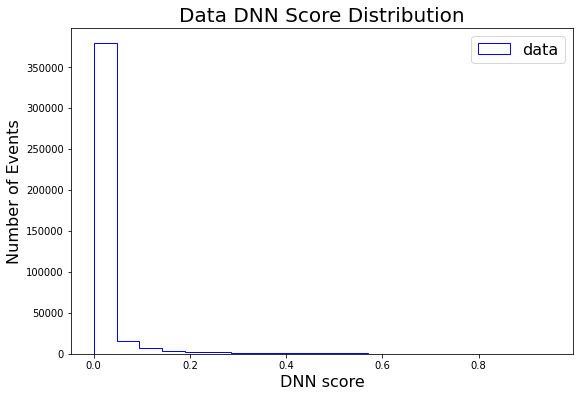

In [53]:
# plot DNN distribution

plt.figure(figsize=(9,6))
plt.hist(DNN_data, color='blue',  histtype='step', bins = 20, label= 'data')
plt.xlabel('DNN score', fontsize=16)
plt.ylabel('Number of Events', fontsize=16)
plt.legend(loc = 'best', fontsize=16)
plt.title('Data DNN Score Distribution', fontsize=20)
plt.savefig(fname = f'DNN_Score_Plts/full/data_DNN_score_v2.png', format='png')
plt.show()

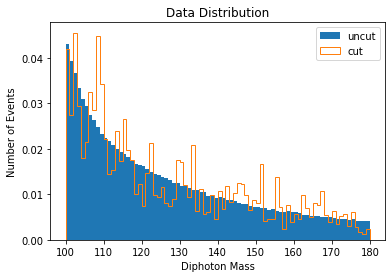

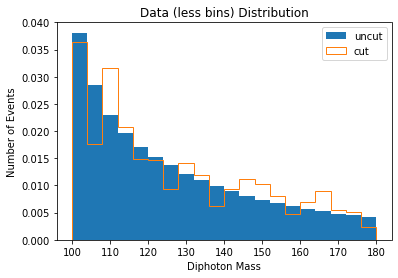

In [54]:
# mass sculpting

bins = np.linspace(100, 180, 81)
FPR = 3
DNN_sc_cuts = DNN_cuts(bins, result_bgd_df_alt, FPR)
result_data_df_sort = data_full_df.sort_values(by = [b'diphoton_mass'])
result_data_df_sort[b'mass_sculpt_cut'] = DNN_cut_pass(bins, result_data_df_sort, DNN_sc_cuts)
plot_mass_sculpt_w_cut(result_data_df_sort, bins, 'Data', FPR, b'mass_sculpt_cut')

bins = np.linspace(100, 180, 21)
FPR = 3
DNN_sc_cuts = DNN_cuts(bins, result_bgd_df_alt, FPR)
result_data_df_sort[b'mass_sculpt_cut_sm'] = DNN_cut_pass(bins, result_data_df_sort, DNN_sc_cuts)
plot_mass_sculpt_w_cut(result_data_df_sort, bins, 'Data (less bins)', FPR, b'mass_sculpt_cut_sm')

In [56]:
training_vars = [b'leading_photon_eta', b'leading_photon_phi', 
                b'subleading_photon_eta', b'subleading_photon_phi',
                 b'leading_bjet_pt_corr', b'leading_bjet_eta', b'leading_bjet_phi',
                 b'subleading_bjet_pt_corr', b'subleading_bjet_eta', b'subleading_bjet_phi',
                 b'leadingDeepBscore', b'subleadingDeepBscore', b'sumDeepBscore',
                 b'leading_pho_pt_over_dimass', b'subleading_pho_pt_over_dimass',
                 b'diphoton_pt_over_diphoton_mass', b'dibjet_pt_over_dibjet_mass_corr',
                 b'rec_pho_bjet_min_dR', b'all_pho_bjet_min_dR', b'dphi_met_leading_bjet', b'dphi_met_subleading_bjet',
                 b'MET_pt', b'MET_phi', b'MET_sumEt',
                 b'nbjet', b'nphoton', b'njet'
                ]

aug_vars = [b'dibjet_mass_corr', b'diphoton_mass', b'event']

w_var = [b'genweight']

new_var = [b'DNN_score', b'mass_sculpt_cut', b'mass_sculpt_cut_sm']

reduced_data_df = result_data_df_sort[training_vars + aug_vars + w_var + new_var]

result_data_df_alt = pd.DataFrame()
for column in list(reduced_data_df.columns):
    result_data_df_alt[column.decode("utf-8")] = reduced_data_df.loc[:, column].values
result_data_df_alt.to_csv('DNN_Trees/combine_sequential_DNN/post_ms/data_result_3_v2.csv', index=False, header=False)
result_data_df_alt.head()

,leading_photon_eta,leading_photon_phi,subleading_photon_eta,subleading_photon_phi,leading_bjet_pt_corr,leading_bjet_eta,leading_bjet_phi,subleading_bjet_pt_corr,subleading_bjet_eta,subleading_bjet_phi,...,nbjet,nphoton,njet,dibjet_mass_corr,diphoton_mass,event,genweight,DNN_score,mass_sculpt_cut,mass_sculpt_cut_sm
0,-1.796387,0.591187,-0.008764,-2.874023,44.531494,-1.444336,-0.665527,39.086609,-0.914307,-2.996094,...,2,2,7,81.729683,100.000000,50044724,1.0,0.000444,0,0
1,-1.762939,-0.750244,-0.547119,-2.622559,78.913208,0.115967,1.056885,71.627930,0.083771,-2.829590,...,2,2,7,142.269943,100.000008,501970951,1.0,0.003344,0,0
2,1.109131,1.316406,0.746948,-1.175049,68.504883,1.031250,-2.347656,50.804535,1.681641,1.015869,...,2,2,7,125.412178,100.000084,417515553,1.0,0.000915,0,0
3,0.275085,1.990967,-0.173035,-0.296326,23.450195,0.626587,-0.573242,29.749817,-1.215576,-3.066895,...,2,2,6,75.853111,100.000099,369572336,1.0,0.008973,0,0
4,1.289551,-0.359070,1.870850,2.314453,34.869507,-0.698608,-1.953857,29.303741,1.728027,-2.795898,...,2,2,6,103.256287,100.000114,964910206,1.0,0.000923,0,0


In [2]:
csv_df_check = pd.read_csv('DNN_Trees/combine_sequential_DNN/post_ms/data_result_3_v2.csv')
csv_df_check.head()

,-1.7963867,0.5911865,-0.008764267,-2.8740234,44.531494,-1.4443359,-0.66552734,39.08661,-0.91430664,-2.9960938,...,2,2.1,7,81.72968,100.0,50044724,1.0,0.00044430795,0,0.1
0,-1.762940,-0.750244,-0.547119,-2.622559,78.913210,0.115967,1.056885,71.627930,0.083771,-2.829590,...,2,2,7,142.26994,100.000010,501970951,1.0,0.003344,0,0
1,1.109131,1.316406,0.746948,-1.175049,68.504880,1.031250,-2.347656,50.804535,1.681641,1.015869,...,2,2,7,125.41218,100.000084,417515553,1.0,0.000915,0,0
2,0.275085,1.990967,-0.173035,-0.296326,23.450195,0.626587,-0.573242,29.749817,-1.215576,-3.066895,...,2,2,6,75.85311,100.000100,369572336,1.0,0.008973,0,0
3,1.289551,-0.359070,1.870850,2.314453,34.869507,-0.698608,-1.953857,29.303741,1.728027,-2.795898,...,2,2,6,103.25629,100.000114,964910206,1.0,0.000923,0,0
4,2.468262,-2.814453,-1.629150,2.797852,70.046906,1.632568,-0.660400,58.929840,0.072067,2.305664,...,2,2,9,171.40271,100.000180,62754101,1.0,0.000630,0,0


In [57]:
# datasidebands 
data_df_mlb = result_data_df_alt[result_data_df_alt['diphoton_mass']<=120]
data_df_mub = result_data_df_alt[result_data_df_alt['diphoton_mass']>=130]
data_df_mwind = pd.concat([data_df_mlb, data_df_mub], ignore_index=True)
data_df_mwind.to_csv('DNN_Trees/combine_sequential_DNN/post_ms/data_sideband_3_v2.csv', index=False, header=False)

In [ ]:
# # save tree

# data_dict_ms = {key.decode("utf-8"): result_data_df_sort[key].values for key in list(result_data_df_sort.columns)}
# data_rdf_ms = rt.RDF.MakeNumpyDataFrame(data_dict_ms)
# data_rdf_ms.Snapshot('tree', f'DNN_Trees/combine_sequential_DNN/post_ms/data_{FPR}.root')

## Using Saved Model

In [7]:
from keras.models import load_model
model_saved = load_model('Models/full/combine_mass_model_1.h5')

2021-10-06 14:22:48.448818: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2021-10-06 14:22:48.471163: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:0c:00.0 name: NVIDIA GeForce GTX TITAN X computeCapability: 5.2
coreClock: 1.2155GHz coreCount: 24 deviceMemorySize: 11.93GiB deviceMemoryBandwidth: 313.37GiB/s
2021-10-06 14:22:48.471198: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2021-10-06 14:22:48.712466: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2021-10-06 14:22:48.839414: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10
2021-10-06 14:22:49.187413: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libc

In [8]:
DNN_data = model_saved.predict(data_)
data_full_df[b'DNN_score'] = DNN_data

2021-10-06 14:22:54.338290: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10


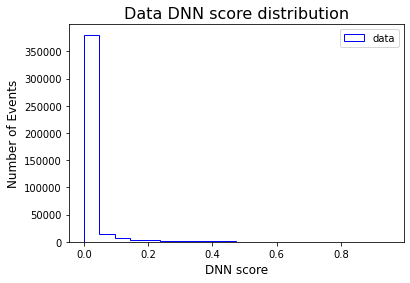

In [53]:
# plot DNN distribution

plt.hist(DNN_data, color='blue',  histtype='step', bins = 20, label= 'data')
plt.xlabel('DNN score', fontsize=12)
plt.ylabel('Number of Events', fontsize=12)
plt.legend(loc = 'best')
plt.title('Data DNN score distribution', fontsize=16)
plt.savefig(fname = f'DNN_Score_Plts/full/data_DNN_score')
plt.show()

In [54]:
# addressing mass sculpting 
def mass_DNN_score(df, FPR_cut, mass_min, mass_max):
    df_range_1 = df[df[b'diphoton_mass'] < mass_max]
    df_range = df_range_1[df_range_1[b'diphoton_mass'] >= mass_min]
    df_values = df_range.sort_values(by = [b'DNN_score'])
    weight_array = df_values.loc[:, b'genweight'].values
    DNN_score_array = df_values.loc[:, b'DNN_score'].values
    total_weight = np.sum(weight_array)
    tn_percent = 1 - FPR_cut
    tn_weight = total_weight * tn_percent
    weight_sum = 0
    for i in range(weight_array.shape[0]):
        weight_sum += weight_array[i]
        if weight_sum >= tn_weight:
            return DNN_score_array[i]
        
def DNN_cuts(bins, df, FPR):
    DNN_cuts = []
    for i in range(bins.shape[0] - 1):
        DNN_cuts.append(mass_DNN_score(df, FPR / 100, bins[i], bins[i+1]))
    return DNN_cuts

def DNN_cut_pass(bins, df, DNN_cuts):
    df_cuts = []
    df_sort = df.sort_values(by = [b'diphoton_mass'])
    for i in range(bins.shape[0] - 1):
        mass_min = bins[i]
        mass_max = bins[i+1]
        df_mass_1 = df_sort[df_sort[b'diphoton_mass'] < mass_max]
        df_mass = df_mass_1[df_mass_1[b'diphoton_mass'] >= mass_min]
        DNN_scores = df_mass.loc[:, b'DNN_score'].values
        for j in range(DNN_scores.shape[0]):
            if DNN_scores[j] >= DNN_cuts[i]:
                df_cuts.append(1)
            else:
                df_cuts.append(0)
    return df_cuts


def plot_mass_sculpt_w_cut(df_sort, mass_bins, samp_name, FPR, key_name):
    ori_mass = df_sort.loc[:, b'diphoton_mass'].values
    ori_weight = df_sort.loc[:, b'genweight'].values
    cut_df = df_sort[df_sort[key_name] == 1]
    cut_mass = cut_df.loc[:, b'diphoton_mass'].values
    cut_weight = cut_df.loc[:, b'genweight'].values
    plt.figure()
    plt.hist(ori_mass, bins = mass_bins, weights = ori_weight, label = 'uncut', density = True)
    plt.hist(cut_mass, bins = mass_bins, range=(100, 180), weights = cut_weight, histtype='step', label = 'cut', density = True )
    plt.legend(loc = 'best')
    plt.xlabel('Diphoton Mass')
    plt.ylabel('Number of Events')
    plt.title(f'{samp_name} Distribution')
    plt.savefig(fname = f'Mass_Sculpt_Plts/full/combine_mgg_{samp_name}_cut_{FPR}')
    plt.show()

In [55]:
samp_file = uproot.open(f'DNN_Trees/combine_sequential_DNN/bgd_combine_seqDNN.root')
samp_array = samp_file['tree'].arrays()
result_bgd_df_saved = pd.DataFrame(samp_array)
result_bgd_df_saved.head()

,b'leading_photon_eta',b'leading_photon_phi',b'subleading_photon_eta',b'subleading_photon_phi',b'leading_bjet_pt_corr',b'leading_bjet_eta',b'leading_bjet_phi',b'subleading_bjet_pt_corr',b'subleading_bjet_eta',b'subleading_bjet_phi',...,b'nbjet',b'nphoton',b'njet',b'genweight',b'dibjet_mass_corr',b'diphoton_mass',b'event',b'label_num',b'genweight_scale',b'DNN_score'
0,-2.085938,-2.799316,-2.034668,0.796143,67.143250,1.063477,-0.480347,59.467484,-1.022705,0.939941,...,3.0,2.0,7.0,1.087711e-02,84.107819,111.086868,47656921.0,11.0,5.714496e-02,0.000786
1,0.107071,-1.744873,-1.057617,1.404297,81.503906,1.076416,1.596924,77.304932,1.547363,-1.484375,...,2.0,2.0,9.0,1.571496e-01,165.074707,109.571030,1249978.0,11.0,8.256152e-01,0.007430
2,0.697754,0.764038,0.792725,2.500000,93.469482,0.560913,-1.602295,58.887329,0.814331,-2.606445,...,2.0,2.0,10.0,5.286534e-08,76.120300,122.875175,2316939.0,1.0,2.777381e-07,0.080799
3,-1.786621,-1.027344,-0.373779,1.015625,236.576538,-1.121582,2.445312,38.845123,1.567871,2.507812,...,3.0,2.0,10.0,3.064775e-02,76.792511,115.246796,960969.0,12.0,1.610138e-01,0.000508
4,-2.302246,1.651367,-0.689697,-1.455811,72.101440,-1.654541,-0.803101,32.862808,-0.146698,1.777100,...,2.0,2.0,6.0,5.141555e-03,125.122887,124.117233,174938.0,5.0,2.701214e-02,0.000417


In [56]:
# mass sculpting
result_data_df_sort = 

bins = np.linspace(100, 180, 21)
FPR = 5
DNN_sc_cuts = DNN_cuts(bins, result_bgd_df_saved, FPR)
result_data_df_sort[b'mass_sculpt_cut_sm'] = DNN_cut_pass(bins, result_data_df_sort, DNN_sc_cuts)
plot_mass_sculpt_w_cut(result_data_df_sort, bins, 'data', FPR, b'mass_sculpt_cut_sm')

bins = np.linspace(100, 180, 81)
FPR = 5
DNN_sc_cuts = DNN_cuts(bins, result_bgd_df_saved, FPR)
result_data_df_sort = data_full_df.sort_values(by = [b'diphoton_mass'])
result_data_df_sort[b'mass_sculpt_cut'] = DNN_cut_pass(bins, result_data_df_sort, DNN_sc_cuts)
plot_mass_sculpt_w_cut(result_data_df_sort, bins, 'data', FPR, b'mass_sculpt_cut')

NameError: name 'result_data_df_sort' is not defined

In [13]:
# save as csv
result_data_df_sort.to_csv('DNN_Trees/combine_sequential_DNN/post_ms/data_result.csv')

In [14]:
result_data_df_sort.head()

,b'run',b'lumi',b'event',b'trig_decision',b'pv_pass',b'njet',b'leading_photon_pt',b'leading_photon_eta',b'leading_photon_phi',b'subleading_photon_pt',...,b'dphi_met_subleading_bjet',b'fatJetPt',b'fatJetEta',b'fatJetPhi',b'fatJetMassSD_UnCorrected',b'fatJetbtagDDBvL',b'good_lumi',b'DNN_score',b'mass_sculpt_cut',b'mass_sculpt_cut_sm'
39845,315642,41,50044724,1,1,7,42.402397,-1.796387,0.591187,29.337294,...,-1.895752,-999.0,-999.0,-999.0,-999.0,-999.0,1,0.000628,0,0
171922,320688,367,501970951,1,1,7,51.786957,-1.762939,-0.750244,45.291508,...,-3.083801,-999.0,-999.0,-999.0,-999.0,-999.0,1,0.006025,0,0
215125,300459,276,417515553,1,1,7,55.885963,1.109131,1.316406,48.041470,...,-1.695068,-999.0,-999.0,-999.0,-999.0,-999.0,1,0.001185,0,0
206067,297723,199,369572336,1,1,6,67.862411,0.275085,1.990967,41.890381,...,0.898908,-999.0,-999.0,-999.0,-999.0,-999.0,1,0.012075,0,0
275830,304447,542,964910206,1,1,6,67.018494,1.289551,-0.359070,36.107933,...,1.100080,-999.0,-999.0,-999.0,-999.0,-999.0,1,0.001265,0,0


In [19]:
result_data_df_alt = pd.DataFrame()
for column in list(result_data_df_sort.columns):
    result_data_df_alt[column.decode("utf-8")] = result_data_df_sort.loc[:, column].values
result_data_df_alt.to_csv('DNN_Trees/combine_sequential_DNN/post_ms/data_result_alt.csv')
result_data_df_alt.head()

,run,lumi,event,trig_decision,pv_pass,njet,leading_photon_pt,leading_photon_eta,leading_photon_phi,subleading_photon_pt,...,dphi_met_subleading_bjet,fatJetPt,fatJetEta,fatJetPhi,fatJetMassSD_UnCorrected,fatJetbtagDDBvL,good_lumi,DNN_score,mass_sculpt_cut,mass_sculpt_cut_sm
0,315642,41,50044724,1,1,7,42.402397,-1.796387,0.591187,29.337294,...,-1.895752,-999.0,-999.0,-999.0,-999.0,-999.0,1,0.000628,0,0
1,320688,367,501970951,1,1,7,51.786957,-1.762939,-0.750244,45.291508,...,-3.083801,-999.0,-999.0,-999.0,-999.0,-999.0,1,0.006025,0,0
2,300459,276,417515553,1,1,7,55.885963,1.109131,1.316406,48.041470,...,-1.695068,-999.0,-999.0,-999.0,-999.0,-999.0,1,0.001185,0,0
3,297723,199,369572336,1,1,6,67.862411,0.275085,1.990967,41.890381,...,0.898908,-999.0,-999.0,-999.0,-999.0,-999.0,1,0.012075,0,0
4,304447,542,964910206,1,1,6,67.018494,1.289551,-0.359070,36.107933,...,1.100080,-999.0,-999.0,-999.0,-999.0,-999.0,1,0.001265,0,0


In [20]:
training_vars = [b'leading_photon_eta', b'leading_photon_phi', 
                b'subleading_photon_eta', b'subleading_photon_phi',
                 b'leading_bjet_pt_corr', b'leading_bjet_eta', b'leading_bjet_phi',
                 b'subleading_bjet_pt_corr', b'subleading_bjet_eta', b'subleading_bjet_phi',
                 b'leadingDeepBscore', b'subleadingDeepBscore', b'sumDeepBscore',
                 b'leading_pho_pt_over_dimass', b'subleading_pho_pt_over_dimass',
                 b'diphoton_pt_over_diphoton_mass', b'dibjet_pt_over_dibjet_mass_corr',
                 b'rec_pho_bjet_min_dR', b'all_pho_bjet_min_dR', b'dphi_met_leading_bjet', b'dphi_met_subleading_bjet',
                 b'MET_pt', b'MET_phi', b'MET_sumEt',
                 b'nbjet', b'nphoton', b'njet'
                ]

aug_vars = [b'dibjet_mass_corr', b'diphoton_mass', b'event']

w_var = [b'genweight']

new_var = [b'DNN_score', b'mass_sculpt_cut', b'mass_sculpt_cut_sm']

reduced_data_df = result_data_df_sort[training_vars + aug_vars + w_var + new_var]

result_data_df_alt = pd.DataFrame()
for column in list(reduced_data_df.columns):
    result_data_df_alt[column.decode("utf-8")] = reduced_data_df.loc[:, column].values
result_data_df_alt.to_csv('DNN_Trees/combine_sequential_DNN/post_ms/data_result_alt.csv', index=False)
result_data_df_alt.head()

,leading_photon_eta,leading_photon_phi,subleading_photon_eta,subleading_photon_phi,leading_bjet_pt_corr,leading_bjet_eta,leading_bjet_phi,subleading_bjet_pt_corr,subleading_bjet_eta,subleading_bjet_phi,...,nbjet,nphoton,njet,dibjet_mass_corr,diphoton_mass,event,genweight,DNN_score,mass_sculpt_cut,mass_sculpt_cut_sm
0,-1.796387,0.591187,-0.008764,-2.874023,44.531494,-1.444336,-0.665527,39.086609,-0.914307,-2.996094,...,2,2,7,81.729683,100.000000,50044724,1.0,0.000628,0,0
1,-1.762939,-0.750244,-0.547119,-2.622559,78.913208,0.115967,1.056885,71.627930,0.083771,-2.829590,...,2,2,7,142.269943,100.000008,501970951,1.0,0.006025,0,0
2,1.109131,1.316406,0.746948,-1.175049,68.504883,1.031250,-2.347656,50.804535,1.681641,1.015869,...,2,2,7,125.412178,100.000084,417515553,1.0,0.001185,0,0
3,0.275085,1.990967,-0.173035,-0.296326,23.450195,0.626587,-0.573242,29.749817,-1.215576,-3.066895,...,2,2,6,75.853111,100.000099,369572336,1.0,0.012075,0,0
4,1.289551,-0.359070,1.870850,2.314453,34.869507,-0.698608,-1.953857,29.303741,1.728027,-2.795898,...,2,2,6,103.256287,100.000114,964910206,1.0,0.001265,0,0


In [5]:
csv_df = pd.read_csv('DNN_Trees/combine_sequential_DNN/post_ms/data_result_alt.csv')
csv_df.head()

,Unnamed: 0,leading_photon_eta,leading_photon_phi,subleading_photon_eta,subleading_photon_phi,leading_bjet_pt_corr,leading_bjet_eta,leading_bjet_phi,subleading_bjet_pt_corr,subleading_bjet_eta,...,nbjet,nphoton,njet,dibjet_mass_corr,diphoton_mass,event,genweight,DNN_score,mass_sculpt_cut,mass_sculpt_cut_sm
0,0,-1.796387,0.591186,-0.008764,-2.874023,44.531494,-1.444336,-0.665527,39.086610,-0.914307,...,2,2,7,81.72968,100.000000,50044724,1.0,0.000628,0,0
1,1,-1.762940,-0.750244,-0.547119,-2.622559,78.913210,0.115967,1.056885,71.627930,0.083771,...,2,2,7,142.26994,100.000010,501970951,1.0,0.006025,0,0
2,2,1.109131,1.316406,0.746948,-1.175049,68.504880,1.031250,-2.347656,50.804535,1.681641,...,2,2,7,125.41218,100.000084,417515553,1.0,0.001185,0,0
3,3,0.275085,1.990967,-0.173035,-0.296326,23.450195,0.626587,-0.573242,29.749817,-1.215576,...,2,2,6,75.85311,100.000100,369572336,1.0,0.012075,0,0
4,4,1.289551,-0.359070,1.870850,2.314453,34.869507,-0.698608,-1.953857,29.303741,1.728027,...,2,2,6,103.25629,100.000114,964910206,1.0,0.001265,0,0


In [10]:
csv_df_new = csv_df.loc[:, csv_df.columns != 'Unnamed: 0']
csv_df_mlb = csv_df_new[csv_df_new['diphoton_mass']<=120]
csv_df_mub = csv_df_new[csv_df_new['diphoton_mass']>=130]
csv_df_mwind = pd.concat([csv_df_mlb, csv_df_mub], ignore_index=True)
csv_df_mwind.to_csv('DNN_Trees/combine_sequential_DNN/post_ms/data_sideband.csv', index=False, header=False)
csv_df_new.head()

,leading_photon_eta,leading_photon_phi,subleading_photon_eta,subleading_photon_phi,leading_bjet_pt_corr,leading_bjet_eta,leading_bjet_phi,subleading_bjet_pt_corr,subleading_bjet_eta,subleading_bjet_phi,...,nbjet,nphoton,njet,dibjet_mass_corr,diphoton_mass,event,genweight,DNN_score,mass_sculpt_cut,mass_sculpt_cut_sm
0,-1.796387,0.591186,-0.008764,-2.874023,44.531494,-1.444336,-0.665527,39.086610,-0.914307,-2.996094,...,2,2,7,81.72968,100.000000,50044724,1.0,0.000628,0,0
1,-1.762940,-0.750244,-0.547119,-2.622559,78.913210,0.115967,1.056885,71.627930,0.083771,-2.829590,...,2,2,7,142.26994,100.000010,501970951,1.0,0.006025,0,0
2,1.109131,1.316406,0.746948,-1.175049,68.504880,1.031250,-2.347656,50.804535,1.681641,1.015869,...,2,2,7,125.41218,100.000084,417515553,1.0,0.001185,0,0
3,0.275085,1.990967,-0.173035,-0.296326,23.450195,0.626587,-0.573242,29.749817,-1.215576,-3.066895,...,2,2,6,75.85311,100.000100,369572336,1.0,0.012075,0,0
4,1.289551,-0.359070,1.870850,2.314453,34.869507,-0.698608,-1.953857,29.303741,1.728027,-2.795898,...,2,2,6,103.25629,100.000114,964910206,1.0,0.001265,0,0


In [10]:
csv_df_new.to_csv('DNN_Trees/combine_sequential_DNN/post_ms/data_result_fix.csv', index=False, header=False)

In [11]:
csv_df_check = pd.read_csv('DNN_Trees/combine_sequential_DNN/post_ms/data_sideband.csv')
csv_df_check.head()

,-1.7963866999999998,0.5911865,-0.008764267,-2.8740234,44.531494,-1.4443358999999998,-0.66552734,39.08661,-0.91430664,-2.9960937999999997,...,2,2.1,7,81.72968,100.0,50044724,1.0,0.00062796474,0,0.1
0,-1.762940,-0.750244,-0.547119,-2.622559,78.913210,0.115967,1.056885,71.627930,0.083771,-2.829590,...,2,2,7,142.26994,100.000010,501970951,1.0,0.006025,0,0
1,1.109131,1.316406,0.746948,-1.175049,68.504880,1.031250,-2.347656,50.804535,1.681641,1.015869,...,2,2,7,125.41218,100.000084,417515553,1.0,0.001185,0,0
2,0.275085,1.990967,-0.173035,-0.296326,23.450195,0.626587,-0.573242,29.749817,-1.215576,-3.066895,...,2,2,6,75.85311,100.000100,369572336,1.0,0.012075,0,0
3,1.289551,-0.359070,1.870850,2.314453,34.869507,-0.698608,-1.953857,29.303741,1.728027,-2.795898,...,2,2,6,103.25629,100.000114,964910206,1.0,0.001265,0,0
4,2.468262,-2.814453,-1.629150,2.797852,70.046906,1.632568,-0.660400,58.929840,0.072067,2.305664,...,2,2,9,171.40271,100.000180,62754101,1.0,0.000731,0,0


In [23]:
s = ''
head_lst = training_vars + aug_vars + w_var + new_var
for header in head_lst:
    s+= header.decode("utf-8") +'/D:'
print(s)

leading_photon_eta/D:leading_photon_phi/D:subleading_photon_eta/D:subleading_photon_phi/D:leading_bjet_pt_corr/D:leading_bjet_eta/D:leading_bjet_phi/D:subleading_bjet_pt_corr/D:subleading_bjet_eta/D:subleading_bjet_phi/D:leadingDeepBscore/D:subleadingDeepBscore/D:sumDeepBscore/D:leading_pho_pt_over_dimass/D:subleading_pho_pt_over_dimass/D:diphoton_pt_over_diphoton_mass/D:dibjet_pt_over_dibjet_mass_corr/D:rec_pho_bjet_min_dR/D:all_pho_bjet_min_dR/D:dphi_met_leading_bjet/D:dphi_met_subleading_bjet/D:MET_pt/D:MET_phi/D:MET_sumEt/D:nbjet/D:nphoton/D:njet/D:dibjet_mass_corr/D:diphoton_mass/D:event/D:genweight/D:DNN_score/D:mass_sculpt_cut/D:mass_sculpt_cut_sm/D:


In [25]:
samp_file = uproot.open(f'DNN_Trees/combine_sequential_DNN/post_ms/data_result.root')
samp_array = samp_file['tree'].arrays()
data_result_saved = pd.DataFrame(samp_array)
data_result_saved.head()

,b'leading_photon_eta',b'leading_photon_phi',b'subleading_photon_eta',b'subleading_photon_phi',b'leading_bjet_pt_corr',b'leading_bjet_eta',b'leading_bjet_phi',b'subleading_bjet_pt_corr',b'subleading_bjet_eta',b'subleading_bjet_phi',...,b'nbjet',b'nphoton',b'njet',b'dibjet_mass_corr',b'diphoton_mass',b'event',b'genweight',b'DNN_score',b'mass_sculpt_cut',b'mass_sculpt_cut_sm'
0,0.0,-1.796387,0.591186,-0.008764,-2.874023,44.531494,-1.444336,-0.665527,39.086610,-0.914307,...,2224.0,2.0,2.0,7.0,81.72968,100.000000,50044724.0,1.0,0,0
1,1.0,-1.762940,-0.750244,-0.547119,-2.622559,78.913210,0.115967,1.056885,71.627930,0.083771,...,1874.0,2.0,2.0,7.0,142.26994,100.000010,501970951.0,1.0,0,0
2,2.0,1.109131,1.316406,0.746948,-1.175049,68.504880,1.031250,-2.347656,50.804535,1.681641,...,1470.0,2.0,2.0,7.0,125.41218,100.000084,417515553.0,1.0,0,0
3,3.0,0.275085,1.990967,-0.173035,-0.296326,23.450195,0.626587,-0.573242,29.749817,-1.215576,...,1616.0,2.0,2.0,6.0,75.85311,100.000100,369572336.0,1.0,0,0
4,4.0,1.289551,-0.359070,1.870850,2.314453,34.869507,-0.698608,-1.953857,29.303741,1.728027,...,1958.0,2.0,2.0,6.0,103.25629,100.000114,964910206.0,1.0,0,0


In [1]:
# # save tree
# from ROOT import RDF
# from ROOT import Internal

# result_data_df_alt = pd.DataFrame()
# for column in list(result_data_df_sort.columns):
#     result_data_df_alt[column] = result_data_df_sort.loc[:, column].values
# data_dict_ms = {key.decode("utf-8"): result_data_df_alt[key].values for key in list(result_data_df_alt.columns)}
# data_rdf_ms = rt.RDF.MakeNumpyDataFrame(data_dict_ms)
# data_rdf_ms.Snapshot('tree', f'DNN_Trees/combine_sequential_DNN/post_ms/data_{FPR}.root')

# Other Checks

In [ ]:
def mc_uncertainty(mc_df):
    weights_unscale = mc_df.loc[:, b'genweight'].values
    total_unscale_weight = np.sum(weights_unscale)
    weights_scale = mc_df.loc[:, b'genweight_scale'].values
    total_scale_weight = np.sum(weights_scale)
    unscale_sum = 0
    for weight in weights_unscale:
        unscale_sum += weight ** 2
    scale_sum = 0
    for weight in weights_scale:
        scale_sum += weight ** 2
    unscale_uncert = np.sqrt(unscale_sum)
    scale_uncert = np.sqrt(scale_sum)
    return (unscale_uncert, total_unscale_weight, scale_uncert, total_scale_weight)

In [ ]:
weights = result_bgd_dfs_lst[0].loc[:, b'genweight'].values
print(weights)
result_bgd_dfs_lst[0].head()
print(result_bgd_df[b'label_num'].value_counts())

In [ ]:
mc_labels = ['VBFToHH',
            'VHToGG', 'ttHToGG', 'VBFHToGG', 'GluGluHtoGG',
            'TTJets', 'TTGJets', 'TTGG_0Jets',
            'GJet_SmallPt', 'GJet_BigPt', 'DiPhotonJetsBox', 'DiPhotonJetsBox1B', 'DiPhotonJetsBox2B', 'QCDJets']
print('(Unscaled Weight Uncertainty, Total Unscaled Weight, Scaled Weight Uncertainty, Total Scaled Weight)')
for i in range(len(mc_labels)):
    print(mc_labels[i])
    print(mc_uncertainty(result_bgd_dfs_lst[i]))

In [ ]:
bins = np.linspace(100, 180, 20)
FPR = 8
DNN_cuts_small = []
for i in range(bins.shape[0] - 1):
    DNN_cuts_small.append(mass_DNN_score(nonresonant_bgd_df_sort, FPR / 100, bins[i], bins[i+1]))
    
print(DNN_cuts_small)

bkd_cut_small = []
sig_cut_small = []
bkd_uncertainty = []

for i in range(bins.shape[0] - 1):
    mass_min = bins[i]
    mass_max = bins[i+1]
    df_bkg = nonresonant_bgd_df_sort[nonresonant_bgd_df_sort[b'diphoton_mass'] <= mass_max][nonresonant_bgd_df_sort[b'diphoton_mass'] >= mass_min]
    df_sig = result_sig_df_sort[result_sig_df_sort[b'diphoton_mass'] <= mass_max][result_sig_df_sort[b'diphoton_mass'] >= mass_min]
    bkg_DNN = df_bkg.loc[:, b'DNN_score'].values
    sig_DNN = df_sig.loc[:, b'DNN_score'].values
    bkg_weights = df_bkg.loc[:, b'genweight'].values
    bkg_weight_total = np.sum(bkg_weights)
    bkg_weight_sum = 0
    for j in range(bkg_DNN.shape[0]):
        if bkg_DNN[j] >= DNN_cuts[i]:
            bkd_cut_small.append(1)
            bkg_weight_sum += bkg_weights[j] ** 2
        else:
            bkd_cut_small.append(0)
    bkd_uncertainty.append((bkg_weight_sum ** 0.5) / bkg_weight_total)
    for k in range(sig_DNN.shape[0]):
        if sig_DNN[k] >= DNN_cuts[i]:
            sig_cut_small.append(1)
        else:
            sig_cut_small.append(0)
nonresonant_bgd_df_sort[b'mass_sculpt_cut_small'] = bkd_cut_small
result_sig_df_sort[b'mass_sculpt_cut_small'] = sig_cut_small

final_bgd_df_small = nonresonant_bgd_df_sort[nonresonant_bgd_df_sort[b'mass_sculpt_cut_small'] == 1]
final_sig_df_small = result_sig_df_sort[result_sig_df_sort[b'mass_sculpt_cut_small'] == 1]
ori_sig_mass_small = result_sig_df_sort.loc[:, b'diphoton_mass'].values
ori_sig_weight_small = result_sig_df_sort.loc[:, b'genweight'].values
cut_sig_mass_small = final_sig_df_small.loc[:, b'diphoton_mass'].values
cut_sig_weight_small = final_sig_df_small.loc[:, b'genweight'].values
ori_bgd_mass_small = nonresonant_bgd_df_sort.loc[:, b'diphoton_mass'].values
ori_bgd_weight_small = nonresonant_bgd_df_sort.loc[:, b'genweight'].values
cut_bgd_mass_small = final_bgd_df_small.loc[:, b'diphoton_mass'].values
cut_bgd_weight_small = final_bgd_df_small.loc[:, b'genweight'].values

# plt.figure()
# plt.hist(ori_sig_mass_small, bins = 20, range=(100, 180), weights = ori_sig_weight_small, label = 'uncut', density = True)
# plt.hist(cut_sig_mass_small, bins = 20, range=(100, 180), weights = cut_sig_weight_small, histtype='step', label = 'cut', density = True )
# plt.legend(loc = 'best')
# plt.xlabel('diphoton mass')
# plt.ylabel('Number of Events')
# plt.title('Signal Distribution')#plt.savefig(fname = f'Mass_Sculpt_Plts/full/combine_mgg_sig_cut_nres_sm{FPR}')
# plt.show()

plt.figure()
plt.hist(ori_bgd_mass_small, bins = np.linspace(100, 180, 20), weights = ori_bgd_weight_small, label = 'uncut', density = True)
#plt.hist(cut_bgd_mass_small, bins = 20, range=(100, 180), weights = cut_bgd_weight_small, histtype='step', label = 'cut', density = True )
y, bin_edges = np.histogram(cut_bgd_mass_small, bins = np.linspace(100, 180, 20), weights = cut_bgd_weight_small,  density = True )
bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])

plt.errorbar(
    bin_centers,
    y,
    yerr = bkd_uncertainty,
    marker = '.',
    drawstyle = 'steps-mid',
    label = 'uncertainty',
)
plt.legend(loc = 'best')
plt.xlabel('diphoton mass')
plt.ylabel('Number of Events')
plt.title('Nonresonant Background Distribution')
plt.savefig(fname = f'Mass_Sculpt_Plts/full/combine_mgg_bgd_cut_nres_sm{FPR}')
plt.show()

In [48]:
for hlf in training_vars:
    plt.figure()
    plt.hist(sig_df[hlf], bins=40, density=True, weights=sig_df[b'genweight'],
             histtype='step', label='signal')
    plt.hist(bkg_df[hlf], bins=40, density=True, weights=bkg_df[b'genweight'], 
             histtype='step', label= 'combined background')
    plt.xlabel(hlf)
    plt.legend(loc='best')
    plt.savefig(fname = f'BackgroundVsSignal_Plts/full/combine_{hlf}_1')
    plt.close()

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame in

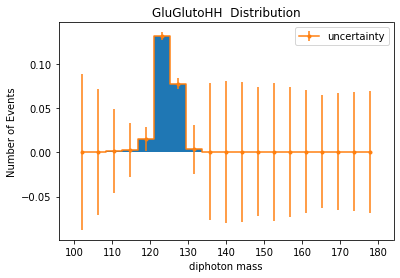

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame in

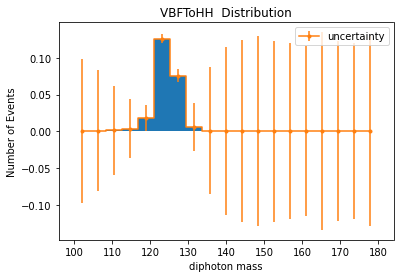

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame in

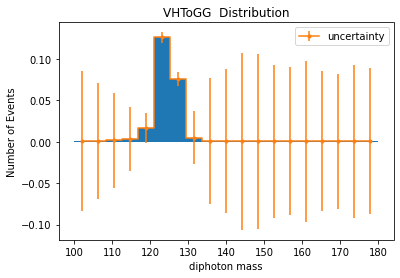

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame in

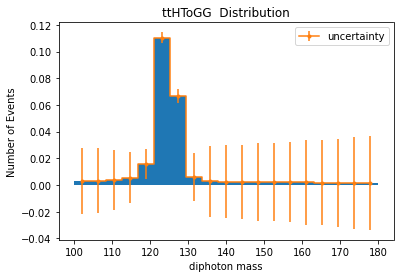

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame in

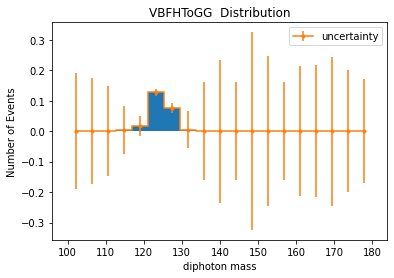

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame in

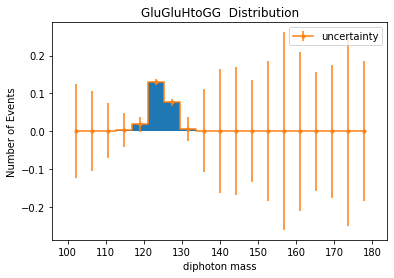

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame in

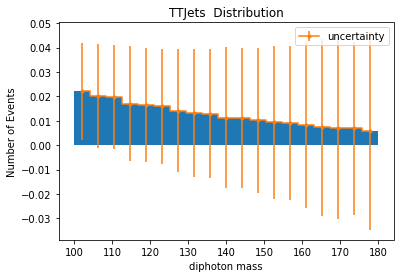

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame in

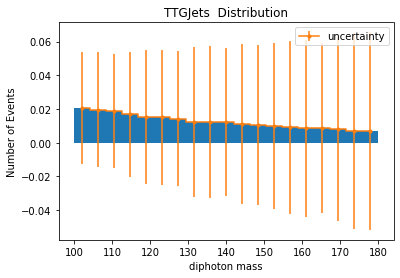

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame in

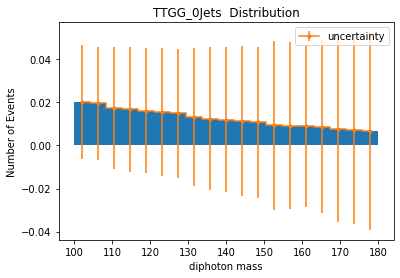

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame in

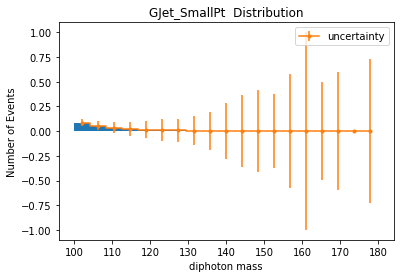

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame in

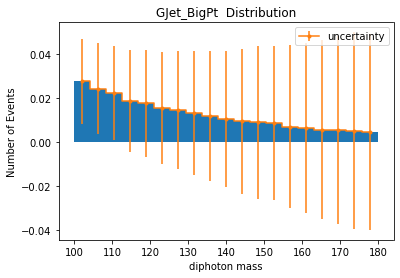

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame in

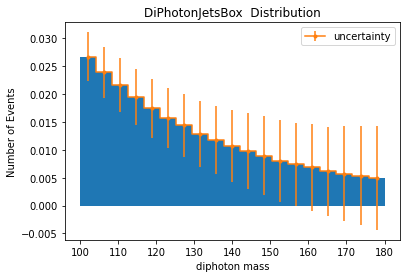

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame in

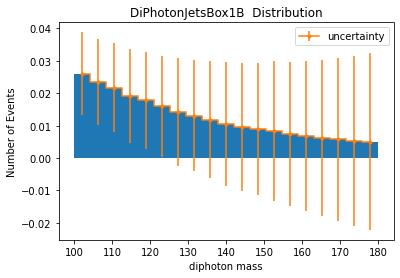

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame in

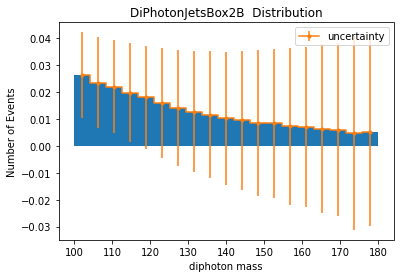

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame in

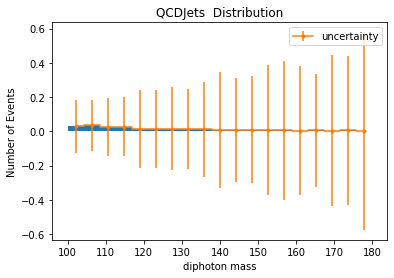

In [58]:
mc_labels = ['GluGlutoHH', 'VBFToHH',
            'VHToGG', 'ttHToGG', 'VBFHToGG', 'GluGluHtoGG',
            'TTJets', 'TTGJets', 'TTGG_0Jets',
            'GJet_SmallPt', 'GJet_BigPt', 'DiPhotonJetsBox', 'DiPhotonJetsBox1B', 'DiPhotonJetsBox2B', 'QCDJets']
bins = np.linspace(100, 180, 20)

for i in range(len(mc_labels)):
    df  = dfs_ggHH_label[i]
    bkd_uncertainty = []

    for j in range(bins.shape[0] - 1):
        mass_min = bins[j]
        mass_max = bins[j+1]
        df_bkg = df[df[b'diphoton_mass'] <= mass_max][df[b'diphoton_mass'] >= mass_min]
        bkg_weights = df_bkg.loc[:, b'genweight'].values
        bkg_weight_total = np.sum(bkg_weights)
        bkg_weight_sum = 0
        for j in range(bkg_weights.shape[0]):
            bkg_weight_sum += bkg_weights[j] ** 2
        bkd_uncertainty.append((bkg_weight_sum ** 0.5) / bkg_weight_total)
    mass = df.loc[:, b'diphoton_mass'].values
    weight = df.loc[:, b'genweight'].values
    plt.figure()
    plt.hist(mass, bins = np.linspace(100, 180, 20), weights = weight,  density = True )
    y, bin_edges = np.histogram(mass, bins = np.linspace(100, 180, 20), weights = weight,  density = True )
    bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])

    plt.errorbar(
        bin_centers,
        y,
        yerr = bkd_uncertainty,
        marker = '.',
        drawstyle = 'steps-mid',
        label = 'uncertainty',
    )
    plt.legend(loc = 'best')
    plt.xlabel('diphoton mass')
    plt.ylabel('Number of Events')
    plt.title(f'{mc_labels[i]}  Distribution')
    #plt.savefig(fname = f'Mass_Sculpt_Plts/full/combine_mgg_bgd_cut_nres_sm{FPR}')
    plt.show()

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Boole

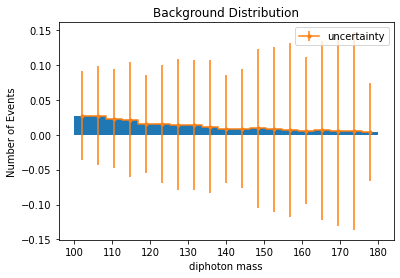

In [56]:
df  = bkg_frame_all
bkd_uncertainty = []

for j in range(bins.shape[0] - 1):
    mass_min = bins[j]
    mass_max = bins[j+1]
    df_bkg = df[df[b'diphoton_mass'] <= mass_max][df[b'diphoton_mass'] >= mass_min]
    bkg_weights = df_bkg.loc[:, b'genweight'].values
    bkg_weight_total = np.sum(bkg_weights)
    bkg_weight_sum = 0
    for j in range(bkg_weights.shape[0]):
        bkg_weight_sum += bkg_weights[j] ** 2
    bkd_uncertainty.append((bkg_weight_sum ** 0.5) / bkg_weight_total)
mass = df.loc[:, b'diphoton_mass'].values
weight = df.loc[:, b'genweight'].values
plt.figure()
plt.hist(mass, bins = np.linspace(100, 180, 20), weights = weight,  density = True )
y, bin_edges = np.histogram(mass, bins = np.linspace(100, 180, 20), weights = weight,  density = True )
bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])

plt.errorbar(
    bin_centers,
    y,
    yerr = bkd_uncertainty,
    marker = '.',
    drawstyle = 'steps-mid',
    label = 'uncertainty',
)
plt.legend(loc = 'best')
plt.xlabel('diphoton mass')
plt.ylabel('Number of Events')
plt.title(f'Background Distribution')
#plt.savefig(fname = f'Mass_Sculpt_Plts/full/combine_mgg_bgd_cut_nres_sm{FPR}')
plt.show()

# 